In [4]:
# ======================================
# CELDA 1: Imports básicos
# ======================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuraciones opcionales para gráficos
plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.1)


In [5]:
# ======================================
# CELDA 2: Cargar bases originales
# ======================================

# Base 2005 (formato Stata en la EPH)
df_05 = pd.read_stata("usu_individual_t105.dta")

# Base 2025 (formato Excel)
df_25 = pd.read_excel("usu_individual_T125.xlsx")

print("2005:", df_05.shape)
print("2025:", df_25.shape)


2005: (47030, 176)
2025: (45425, 235)


In [6]:
# ======================================
# CELDA 3: Normalizar y unificar (base_final)
# ======================================

# Copias de trabajo
df2005 = df_05.copy()
df2025 = df_25.copy()

# Paso 1: renombrar columnas de 2005 a mayúsculas para que coincidan con 2025
ren_2005 = {c: c.upper() for c in df2005.columns}
df2005 = df2005.rename(columns=ren_2005)

# Paso 2: detectar columnas comunes
comunes = sorted(set(df2005.columns) & set(df2025.columns))

# Paso 3: alinear las columnas
# columnas únicas de cada base
cols_2005_unicas = sorted(set(df2005.columns) - set(comunes))
cols_2025_unicas = sorted(set(df2025.columns) - set(comunes))

df2005_aligned = df2005.copy()
df2025_aligned = df2025.copy()

# agregar columnas que le faltan a cada base
for col in cols_2025_unicas:
    df2005_aligned[col] = pd.NA
for col in cols_2005_unicas:
    df2025_aligned[col] = pd.NA

# reordenar para que coincidan
df2005_aligned = df2005_aligned[sorted(df2005_aligned.columns)]
df2025_aligned = df2025_aligned[sorted(df2025_aligned.columns)]

# Paso 4: concatenar
base_final = pd.concat([df2005_aligned, df2025_aligned], ignore_index=True)

print("Base final creada con tamaño:", base_final.shape)
display(base_final.head())


/var/folders/gt/s4fbknnd2_ld7p8jjqmlyhxh0000gp/T/ipykernel_80810/3418770857.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  base_final = pd.concat([df2005_aligned, df2025_aligned], ignore_index=True)
/var/folders/gt/s4fbknnd2_ld7p8jjqmlyhxh0000gp/T/ipykernel_80810/3418770857.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  base_final = pd.concat([df2005_aligned, df2025_aligned], ignore_index=True)
/var/folders/gt/s4fbknnd2_ld7p8jjqmlyhxh0000gp/T/ipykernel_80810/3418770857.py:35: FutureW

Base final creada con tamaño: (92455, 243)


,ADECCFR,ADECIFR,ADECINDR,ADECOCUR,AGLOMERADO,ANO4,CAT_INAC,CAT_OCUP,CH03,CH04,...,V2_03_M,V2_M,V3_M,V4_M,V5_01_M,V5_02_M,V5_03_M,V5_M,V8_M,V9_M
0,05,02,04,,Ciudad de Buenos Aires,2005.0,Jubilado/pensionado,0.0,Jefe,Varón,...,<NA>,583.0,0.0,0.0,<NA>,<NA>,<NA>,0.0,0.0,0.0
1,01,02,03,02,Ciudad de Buenos Aires,2005.0,0.0,Cuenta propia,Jefe,Varón,...,<NA>,0.0,0.0,0.0,<NA>,<NA>,<NA>,0.0,0.0,0.0
2,01,02,00,,Ciudad de Buenos Aires,2005.0,Ama de casa,0.0,Cónyuge/Pareja,Mujer,...,<NA>,0.0,0.0,0.0,<NA>,<NA>,<NA>,0.0,0.0,0.0
3,01,02,00,,Ciudad de Buenos Aires,2005.0,Menor de 6 años,0.0,Hijo/Hijastro,Mujer,...,<NA>,0.0,0.0,0.0,<NA>,<NA>,<NA>,0.0,0.0,0.0
4,07,03,06,,Ciudad de Buenos Aires,2005.0,Jubilado/pensionado,0.0,Jefe,Mujer,...,<NA>,575.0,0.0,0.0,<NA>,<NA>,<NA>,0.0,0.0,0.0


In [7]:
# ======================================
# CELDA 4 ROBUSTA: ingreso_total_familiar, ingreso_necesario, pobre, Patagonia
# ======================================

import pandas as pd
import numpy as np

base_final.columns = base_final.columns.str.strip().str.lower()

# --- A) asegurar ingreso_total_familiar en pesos 2025 ---
if "ingreso_total_familiar" not in base_final.columns:
    if "itf" not in base_final.columns or "ano4" not in base_final.columns:
        raise KeyError("Faltan 'ingreso_total_familiar' y también 'itf'/'ano4' para poder construirlo.")
    base_final["itf"] = pd.to_numeric(base_final["itf"], errors="coerce")
    factor_2005_a_2025 = 365_177 / 205.07  # CBA 2025 / CBA 2005 (del TP1)
    base_final["ingreso_total_familiar"] = base_final["itf"]
    base_final.loc[base_final["ano4"] == 2005, "ingreso_total_familiar"] = \
        base_final.loc[base_final["ano4"] == 2005, "itf"] * factor_2005_a_2025

# --- B) ingreso_necesario (si falta) ---
if "ingreso_necesario" not in base_final.columns:
    cba_2025 = 365_177  # del TP1
    if "cba_adulto_equiv" in base_final.columns and "ad_equiv_hogar" in base_final.columns:
        base_final["ingreso_necesario"] = pd.to_numeric(base_final["cba_adulto_equiv"], errors="coerce") * \
                                          pd.to_numeric(base_final["ad_equiv_hogar"], errors="coerce")
        print("✅ ingreso_necesario calculado con cba_adulto_equiv * ad_equiv_hogar.")
    elif "tot_p12" in base_final.columns:
        # Fallback aproximado: CBA * tamaño del hogar (reemplazar por equivalencias adultas cuando las tengan)
        base_final["ingreso_necesario"] = cba_2025 * pd.to_numeric(base_final["tot_p12"], errors="coerce")
        print("⚠️ ingreso_necesario aproximado: 365,177 * tot_p12. Sustituí por equivalencias adultas cuando estén listas.")
    else:
        raise KeyError("No tengo 'ingreso_necesario' ni puedo derivarlo (faltan 'cba_adulto_equiv'/'ad_equiv_hogar' o 'tot_p12').")

# --- C) crear 'pobre' ---
ing = pd.to_numeric(base_final["ingreso_total_familiar"], errors="coerce")
nec = pd.to_numeric(base_final["ingreso_necesario"], errors="coerce")
mask_valid = ing.notna() & nec.notna()
base_final["pobre"] = pd.Series(pd.NA, index=base_final.index, dtype="Int64")
base_final.loc[mask_valid, "pobre"] = (ing[mask_valid] < nec[mask_valid]).astype(int).astype("Int64")

# --- D) flag 'patagonia' desde 'region' ---
def es_patagonia(val):
    if pd.isna(val):
        return False
    s = str(val).strip().lower()
    # ajustá '6' si tu codificación difiere; si 'region' es texto, debe ser 'patagonia'
    return s == "patagonia" or s == "6"

base_final["patagonia"] = base_final["region"].apply(es_patagonia).astype(int)

print("Listo: columnas creadas ->", {"pobre": base_final["pobre"].notna().sum(),
                                     "patagonia==1": int((base_final["patagonia"]==1).sum())})


/var/folders/gt/s4fbknnd2_ld7p8jjqmlyhxh0000gp/T/ipykernel_80810/993626075.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  base_final["ingreso_total_familiar"] = base_final["itf"]
/var/folders/gt/s4fbknnd2_ld7p8jjqmlyhxh0000gp/T/ipykernel_80810/993626075.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  base_final["ingreso_necesario"] = cba_2025 * pd.to_numeric(base_final["tot_p12"], errors="coerce")
/var/folders/gt/s4fbknnd2_ld7p8jjqmlyhxh0000gp/T/ipykernel_80810/993626075.py:38: PerformanceWarning: DataFrame is highly 

⚠️ ingreso_necesario aproximado: 365,177 * tot_p12. Sustituí por equivalencias adultas cuando estén listas.
Listo: columnas creadas -> {'pobre': np.int64(92455), 'patagonia==1': 0}


/var/folders/gt/s4fbknnd2_ld7p8jjqmlyhxh0000gp/T/ipykernel_80810/993626075.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  base_final["patagonia"] = base_final["region"].apply(es_patagonia).astype(int)


In [8]:
# Consigna 0


import pandas as pd

# Reemplaza 'tu_archivo.dta' por el nombre exacto de tu archivo
df_05 = pd.read_stata('usu_individual_t105.dta')

# Reemplaza 'tu_archivo.dta' por el nombre exacto de tu archivo
df_25 = pd.read_excel('usu_individual_T125.xlsx')

adulto_equiv = pd.read_excel('tabla_adulto_equiv.xlsx')

# Muestra las primeras filas para verificar
df_05.head()
df_25.head()

print(df_05.head())
print(df_25.head())

     CODUSU  nro_hogar componente  h15    ano4       trimestre  \
0  125098          1.0        1.0   Sí  2005.0  1er. Trimestre   
1  125188          1.0        1.0   Sí  2005.0  1er. Trimestre   
2  125188          1.0        2.0   Sí  2005.0  1er. Trimestre   
3  125188          1.0        3.0  0.0  2005.0  1er. Trimestre   
4  125242          1.0        1.0   Sí  2005.0  1er. Trimestre   

              region mas_500              aglomerado  pondera  ... deccfr  \
0  Gran Buenos Aires       S  Ciudad de Buenos Aires   1017.0  ...     08   
1  Gran Buenos Aires       S  Ciudad de Buenos Aires   1062.0  ...     02   
2  Gran Buenos Aires       S  Ciudad de Buenos Aires   1062.0  ...     02   
3  Gran Buenos Aires       S  Ciudad de Buenos Aires   1062.0  ...     02   
4  Gran Buenos Aires       S  Ciudad de Buenos Aires   1103.0  ...     09   

  ideccfr rdeccfr gdeccfr pdeccfr adeccfr pj1_1 pj2_1 pj3_1 idimpp  
0              07      08              05   0.0   0.0   0.0  00000  
1 

In [9]:
# Consigna 0


# Junto ambas bases
import pandas as pd

# Reemplaza 'tu_archivo.dta' por el nombre exacto de tu archivo
df_05 = pd.read_stata('usu_individual_t105.dta')

# Reemplaza 'tu_archivo.dta' por el nombre exacto de tu archivo
df_25 = pd.read_excel('usu_individual_T125.xlsx')


#Una vez visto el formato de cada variable, pasamos el formato de las de 2005, igual al de 2025.
import pandas as pd
import numpy as np
from pandas.api.types import is_integer_dtype, is_float_dtype


# 0) Copia y normalizo nombres

df2005 = df_05.copy()
df2025 = df_25.copy()

# renombro columnas de 2005 a MAYÚSCULAS para alinearlas con 2025
ren_2005 = {c: c.upper() for c in df2005.columns}
df2005 = df2005.rename(columns=ren_2005)


# 1) dtypes objetivo (2025)

target_dtypes = df2025.dtypes  #yo quiero todo igual al 2025.

# columnas comunes (por nombre ya en mayúsculas)
comunes = sorted(set(df2005.columns) & set(df2025.columns))


# 2) Mapeos especiales (texto a códigos)

SPECIAL_MAPS = {
    "CH04": {  # sexo: texto a 1/2
        "1": 1, "varon": 1, "varón": 1, "hombre": 1, "m": 1, "masculino": 1,
        "2": 2, "mujer": 2, "f": 2, "femenino": 2
    },
}

def apply_special_map(series: pd.Series, col: str) -> pd.Series:
    if col not in SPECIAL_MAPS:
        return series
    # normalizo a string-lower y mapeo
    m = SPECIAL_MAPS[col]
    s = series.astype("string").str.strip().str.lower()
    return s.map(m)# 3) Conversión columna a columna

def convert_to_target(s: pd.Series, target_dtype) -> pd.Series:
    """
    Convierte s al dtype de 2025:
      - int64  -> numérico y luego Int64 (si no hay NaN, baja a int64)
      - float64-> numérico float
      - object -> a object/string
      - category en 2005 se elimina (paso intermedio a object)
    """
    # sacar 'category' si viene así de 2005
    if str(s.dtype) == "category":
        s = s.astype("object")

    # int objetivo
    if is_integer_dtype(target_dtype):
        s_num = pd.to_numeric(s, errors="coerce")
        out = s_num.round().astype("Int64")
        # si no hay NA, convierto a numpy int64 puro (opcional)
        if out.isna().sum() == 0:
            out = out.astype("int64")
        return out

    # float objetivo
    if is_float_dtype(target_dtype):
        return pd.to_numeric(s, errors="coerce").astype("float64")

    # object objetivo
    return s.astype("object")

# hago una copia donde ir dejando las columnas ya convertidas
df2005_conv = df2005.copy()

log = []  # para ver qué se hizo

for col in comunes:
    tgt = target_dtypes[col]

    # 1) mapeo especial si aplica (por ej. CH04)
    mapped = apply_special_map(df2005_conv[col], col)
    if col in SPECIAL_MAPS:
        # si hubo mapeo, reemplazo donde haya valor mapeado
        df2005_conv[col] = mapped.where(mapped.notna(), df2005_conv[col])

    # 2) convierto al dtype de 2025
    before = str(df2005_conv[col].dtype)
    df2005_conv[col] = convert_to_target(df2005_conv[col], tgt)
    after = str(df2005_conv[col].dtype)

    log.append((col, before, str(tgt), after))


# 4) Resumen de el pase de variable

resumen = pd.DataFrame(log, columns=["columna", "dtype_2005_origen", "dtype_2025_objetivo", "dtype_2005_final"])
resumen = resumen.sort_values("columna").reset_index(drop=True)

print("Conversión realizada sobre", len(comunes), "columnas comunes.")
display(resumen.head(20))

# df2005_conv es la  base de 2005 armonizada a los formatos de 2025
# (mismos nombres en MAYÚSCULA y dtypes compatibles con 2025)
#ahora que esto funciona, vamos a trabajr con:
#df 2005 = df2005_conv
#df 2025 = df_T125

Conversión realizada sobre 168 columnas comunes.


,columna,dtype_2005_origen,dtype_2025_objetivo,dtype_2005_final
0,ADECCFR,object,int64,int64
1,ADECIFR,object,int64,int64
2,ADECINDR,object,int64,int64
3,ADECOCUR,object,int64,Int64
4,AGLOMERADO,category,int64,Int64
5,ANO4,float64,int64,int64
6,CAT_INAC,category,int64,Int64
7,CAT_OCUP,category,int64,Int64
8,CH03,category,int64,Int64
9,CH04,int64,int64,int64


In [10]:
# Consigna 0



#5) Alinear columnas y juntar

# columnas únicas a cada dataframe
cols_2005_unicas = sorted(set(df2005_conv.columns) - set(comunes))
cols_2025_unicas = sorted(set(df2025.columns) - set(comunes))


# creo copias para no modificar los df originales
df2005_aligned = df2005_conv.copy()
df2025_aligned = df2025.copy()


# agrego columnas únicas de 2025 a 2005 (con NaN)
for col in cols_2025_unicas:
    df2005_aligned[col] = pd.NA  # o pd.NA o np.nan según el dtype

# agrego columnas únicas de 2005 a 2025 (con NaN)
for col in cols_2005_unicas:
    df2025_aligned[col] = pd.NA # o pd.NA o np.nan según el dtype


# reordeno columnas para que estén en el mismo orden
df2005_aligned = df2005_aligned[sorted(df2005_aligned.columns)]
df2025_aligned = df2025_aligned[sorted(df2025_aligned.columns)]


# verifico que tengan las mismas columnas y en el mismo orden
if not df2005_aligned.columns.equals(df2025_aligned.columns):
    print("Error: Las columnas no coinciden después de alinear.")
else:
    print("Columnas alineadas correctamente.")
    # concateno
    base_final = pd.concat([df2005_aligned, df2025_aligned], ignore_index=True)
    print("Bases concatenadas. Tamaño de base_final:", base_final.shape)

# Display a random sample of the final dataframe
display(base_final.sample(5))

Columnas alineadas correctamente.


/var/folders/gt/s4fbknnd2_ld7p8jjqmlyhxh0000gp/T/ipykernel_80810/4221881088.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  base_final = pd.concat([df2005_aligned, df2025_aligned], ignore_index=True)
/var/folders/gt/s4fbknnd2_ld7p8jjqmlyhxh0000gp/T/ipykernel_80810/4221881088.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  base_final = pd.concat([df2005_aligned, df2025_aligned], ignore_index=True)
/var/folders/gt/s4fbknnd2_ld7p8jjqmlyhxh0000gp/T/ipykernel_80810/4221881088.py:37: FutureW

Bases concatenadas. Tamaño de base_final: (92455, 243)


,ADECCFR,ADECIFR,ADECINDR,ADECOCUR,AGLOMERADO,ANO4,CAT_INAC,CAT_OCUP,CH03,CH04,...,V2_03_M,V2_M,V3_M,V4_M,V5_01_M,V5_02_M,V5_03_M,V5_M,V8_M,V9_M
37670,7,6,0,<NA>,<NA>,2005,<NA>,0,<NA>,2,...,<NA>,0.0,0,0,<NA>,<NA>,<NA>,0.0,0,0
18959,2,4,3,3,<NA>,2005,0,<NA>,<NA>,2,...,<NA>,0.0,0,0,<NA>,<NA>,<NA>,0.0,0,0
77887,2,4,0,0,12,2025,3,0,3,1,...,0,NaN,0,0,0,0,0,NaN,0,0
3895,9,9,8,8,<NA>,2005,0,<NA>,<NA>,1,...,<NA>,0.0,0,0,<NA>,<NA>,<NA>,0.0,0,0
36461,6,7,8,9,<NA>,2005,0,<NA>,<NA>,1,...,<NA>,0.0,0,0,<NA>,<NA>,<NA>,0.0,0,0


/var/folders/gt/s4fbknnd2_ld7p8jjqmlyhxh0000gp/T/ipykernel_80810/2447353314.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  base_final["EDAD2"] = (base_final["CH06"] ** 2).astype("float64")


Text(0, 0.5, 'Frecuencia')

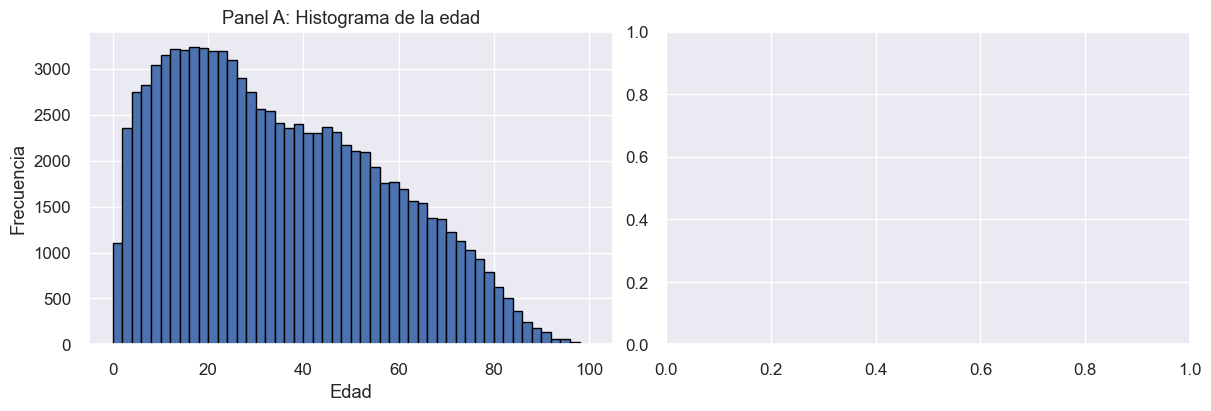

In [11]:
# Consigna 1



# Creo la variable edad2 y hago un histograma de su distribución

import matplotlib.pyplot as plt

base_final["CH06"] = pd.to_numeric(base_final["CH06"], errors="coerce")

# crear edad2
base_final["EDAD2"] = (base_final["CH06"] ** 2).astype("float64")

# opcional: defragmentar para evitar warnings futuros
base_final = base_final.copy()

# datos para el histograma
edad = base_final["CH06"].dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

# Panel A: histograma de edad
axes[0].hist(edad, bins=np.arange(0, 101, 2), edgecolor="black")
axes[0].set_title("Panel A: Histograma de la edad")
axes[0].set_xlabel("Edad")
axes[0].set_ylabel("Frecuencia")


In [12]:
# Consigna 1



# Inserto la construcción del Indicador de Pobreza del TP1

# Asegurar que ESTADO sea numérico (si quedó como texto "0", lo convierte)
base_final["ESTADO"] = pd.to_numeric(base_final["ESTADO"], errors="coerce")

# Ver si aparecen 0 o NaN
print("¿Hay 0 en ESTADO? ", (base_final["ESTADO"] == 0).any())
print("¿Hay NaN en ESTADO?", base_final["ESTADO"].isna().any())

# Conteo total de no respuesta (0 o NaN)
mask_no_resp = base_final["ESTADO"].isna() | (base_final["ESTADO"] == 0)
n_total = len(base_final)
n_no    = mask_no_resp.sum()
print(f"\nNo respondieron condición de actividad (0 o NaN): {n_no} de {n_total}  ({n_no/n_total:.1%})")

# Detalle por año
if "ANO4" in base_final.columns:
    resumen = (base_final.assign(no_resp=mask_no_resp)
                          .groupby("ANO4")["no_resp"]
                          .agg(no_resp="sum", total="size"))
    resumen["pct"] = 100 * resumen["no_resp"] / resumen["total"]
    print("\nPor año (2005 vs 2025):\n", resumen)


print(base_final["ESTADO"].value_counts(dropna=False).sort_index()) # Mirar los valores que tiene ESTADO

¿Hay 0 en ESTADO?  True
¿Hay NaN en ESTADO? True

No respondieron condición de actividad (0 o NaN): 47105 de 92455  (50.9%)

Por año (2005 vs 2025):
       no_resp  total       pct
ANO4                          
2005    47030  47030     100.0
2025       75  45425  0.165107
ESTADO
0          75
1       20076
2        1381
3       18866
4        5027
<NA>    47030
Name: count, dtype: Int64


In [13]:
# Consigna 1



# Asegurar numérico
if "ITF" in base_final.columns:
    base_final["ITF"] = pd.to_numeric(base_final["ITF"], errors="coerce")
else:
    print("Warning: 'ITF' column not found in base_final.")


# respondieron ITF (1 si ITF>0 and not NaN; 0 if ITF==0 or NaN) ===
# Using base_final directly
base_final["respondio_ITF"] = np.where(base_final["ITF"].notna() & (base_final["ITF"] > 0), 1, 0).astype("int8")


#  Bases pedidas por consigna ===
respondieron  = base_final.query("respondio_ITF == 1").copy()
norespondieron = base_final.query("respondio_ITF == 0").copy()

# === Resúmenes útiles para el informe ===
# Respondieron vs no respondieron por año
if "ANO4" in base_final.columns:
    resumen_itf = (
        base_final.groupby(["ANO4","respondio_ITF"]).size()
          .unstack(fill_value=0)
          .rename(columns={0:"norespondieron_ITF", 1:"respondieron_ITF"})
          .reset_index()
    )
    resumen_itf["tasa_noresp"] = resumen_itf["norespondieron_ITF"] / (
        resumen_itf["norespondieron_ITF"] + resumen_itf["respondieron_ITF"]
    )


    print("Resumen ITF por año:")
    print(resumen_itf)
else:
    print("Warning: 'ANO4' column not found in base_final. Cannot group by year.")

Resumen ITF por año:
respondio_ITF  ANO4  norespondieron_ITF  respondieron_ITF  tasa_noresp
0              2005                 438             46592     0.009313
1              2025               12053             33372     0.265338


In [14]:
# Consigna 1



# Empiezo a usar la base de los que respondieron sobre sus ingresos


def cargar_tabla_adulto_equiv_simple(path="tabla_adulto_equiv.xlsx", verbose=True):
    # Leer todo como string para no “romper” nada al principio
    raw = pd.read_excel(path, header=None, dtype=str)

    # 1) Detectar automáticamente la fila y las 3 columnas correctas: Edad | Mujeres | Varones
    hdr_row = None
    col_edad = col_muj = col_var = None
    for r in range(len(raw)):
        row = raw.iloc[r].astype(str).str.strip().str.lower()
        for c in range(len(row) - 2):
            a, b, d = row.iloc[c], row.iloc[c+1], row.iloc[c+2]
            if a == "edad" and "mujer" in b and ("varon" in d or "varón" in d):
                hdr_row, col_edad, col_muj, col_var = r, c, c+1, c+2
                break
        if hdr_row is not None:
            break

    if hdr_row is None:
        raise ValueError("No encontré encabezados 'Edad | Mujeres | Varones' en el archivo.")

    if verbose:
        print(f"Encabezado detectado en fila {hdr_row} | columnas: EDAD={col_edad}, MUJERES={col_muj}, VARONES={col_var}")

    # 2) Quedarnos con esas 3 columnas desde la fila siguiente
    tbl = raw.iloc[hdr_row+1:, [col_edad, col_muj, col_var]].copy()
    tbl.columns = ["EDAD", "MUJERES", "VARONES"]

    # 3) Limpiar EDAD (espacios raros) y pasar equivalencias a número (coma -> punto)
    tbl["EDAD"] = (tbl["EDAD"].fillna("")
                             .str.replace("\xa0", " ", regex=False)
                             .str.strip()
                             .str.replace(r"\s+", " ", regex=True))

    for c in ["MUJERES", "VARONES"]:
        s = tbl[c].fillna("").str.replace("\xa0", " ", regex=False).str.strip()
        s = s.str.replace(",", ".", regex=False)  # por si vienen con coma decimal
        tbl[c] = pd.to_numeric(s, errors="coerce")

    # 4) Quitar filas basura (todas NaN o textos tipo 'Ejemplos...', 'Fuente...')
    basura = tbl["EDAD"].str.lower().str.contains("ejemplo|fuente|indec", na=False)
    todo_nan = tbl[["MUJERES","VARONES"]].isna().all(axis=1)
    tbl = tbl[~(basura | todo_nan)].reset_index(drop=True)

    return tbl

# === USO ===
adulto_equiv = cargar_tabla_adulto_equiv_simple("tabla_adulto_equiv.xlsx")

# 1) quitar la cabecera repetida
mask_midheader = adulto_equiv["EDAD"].astype(str).str.strip().str.lower().eq("edad")

# 2) quitar filas “basura” donde MUJERES y VARONES son ambos NaN
mask_allnan = adulto_equiv[["MUJERES","VARONES"]].isna().all(axis=1)

adulto_equiv = adulto_equiv[~(mask_midheader | mask_allnan)].reset_index(drop=True)

print(adulto_equiv)

Encabezado detectado en fila 3 | columnas: EDAD=0, MUJERES=1, VARONES=2
              EDAD  MUJERES  VARONES
0   Menor de 1 año     0.35     0.35
1             1año     0.37     0.37
2           2 años     0.46     0.46
3           3 años     0.51     0.51
4           4 años     0.55     0.55
5           5 años     0.60     0.60
6           6 años     0.64     0.64
7           7 años     0.66     0.66
8           8 años     0.68     0.68
9           9 años     0.69     0.69
10         10 años     0.70     0.79
11         11 años     0.72     0.82
12         12 años     0.74     0.85
13         13 años     0.76     0.90
14         14 años     0.76     0.96
15         15 años     0.77     1.00
16         16 años     0.77     1.03
17         17 años     0.77     1.04
18    18 a 29 años     0.76     1.02
19    30 a 45 años     0.77     1.00
20    46 a 60 años     0.76     1.00
21    61 a 75 años     0.67     0.83
22  más de 75 años     0.63     0.74


In [15]:
# Consigna 1



# Merge base "respondieron" with adulto_equiv to get the 'adulto_equiv' value for each person
# Need to prepare adulto_equiv for merging by creating age ranges and mapping sex codes
def map_age_to_range(age):
    # Ensure age is treated as numeric, handle potential NaNs or conversion errors
    if pd.isna(age):
        return np.nan
    try:
        age = int(age)
    except ValueError:
        return np.nan # Handle cases where conversion to int fails

    if age < 1:
        return "Menor de 1 año"
    elif age == 1:
        return "1año"
    elif age == 2:
        return "2 años"
    elif age == 3:
        return "3 años"
    elif age == 4:
        return "4 años"
    elif age == 5:
        return "5 años"
    elif age == 6:
        return "6 años"
    elif age == 7:
        return "7 años"
    elif age == 8:
        return "8 años"
    elif age == 9:
        return "9 años"
    elif age == 10:
        return "10 años"
    elif age == 11:
        return "11 años"
    elif age == 12:
        return "12 años"
    elif age == 13:
        return "13 años"
    elif age == 14:
        return "14 años"
    elif age == 15:
        return "15 años"
    elif age == 16:
        return "16 años"
    elif age == 17:
        return "17 años"
    elif 18 <= age <= 29:
        return "18 a 29 años"
    elif 30 <= age <= 45:
        return "30 a 45 años"
    elif 46 <= age <= 60:
        return "46 a 60 años"
    elif 61 <= age <= 75:
        return "61 a 75 años"
    elif age > 75:
        return "más de 75 años"
    else:
        return np.nan

# Ensure CH06 is numeric
respondieron['CH06'] = pd.to_numeric(respondieron['CH06'], errors='coerce')

respondieron['EDAD_RANGO'] = respondieron['CH06'].apply(map_age_to_range)

# Map sex codes to column names in adulto_equiv
respondieron['SEXO_COL'] = respondieron['CH04'].map({1: 'VARONES', 2: 'MUJERES'})

# Merge to get the adulto_equiv value
# Perform a left merge from base_final to adulto_equiv
respondieron = pd.merge(respondieron, adulto_equiv, left_on='EDAD_RANGO', right_on='EDAD', how='left')


# Select the correct adulto_equiv value based on sex
respondieron['adulto_equiv'] = respondieron.apply(lambda row: row[row['SEXO_COL']] if pd.notna(row['SEXO_COL']) and pd.notna(row['EDAD_RANGO']) else np.nan, axis=1)

# Drop the intermediate columns used for merging
respondieron = respondieron.drop(columns=['EDAD_RANGO', 'SEXO_COL', 'EDAD', 'MUJERES', 'VARONES'], errors='ignore')

# Recalculate adults equivalentes por hogar (uses both keys)
# Use base_final directly
respondieron["ad_equiv_hogar"] = (
    respondieron
    .groupby(["CODUSU", "NRO_HOGAR"])["adulto_equiv"]
    .transform("sum")
)


# Chequeo rápido
print(respondieron[["CODUSU","NRO_HOGAR","adulto_equiv","ad_equiv_hogar"]].head())


display(respondieron.head())

     CODUSU  NRO_HOGAR  adulto_equiv  ad_equiv_hogar
0  125098            1          0.74            0.74
1  125188            1          1.02            1.78
2  125188            1          0.76            1.78
3  125188            1           NaN            1.78
4  125242            1          0.67            0.67


,ADECCFR,ADECIFR,ADECINDR,ADECOCUR,AGLOMERADO,ANO4,CAT_INAC,CAT_OCUP,CH03,CH04,...,V5_01_M,V5_02_M,V5_03_M,V5_M,V8_M,V9_M,EDAD2,respondio_ITF,adulto_equiv,ad_equiv_hogar
0,5,2,4,<NA>,<NA>,2005,<NA>,0,<NA>,1,...,<NA>,<NA>,<NA>,0.0,0,0,6400.0,1,0.74,0.74
1,1,2,3,2,<NA>,2005,0,<NA>,<NA>,1,...,<NA>,<NA>,<NA>,0.0,0,0,676.0,1,1.02,1.78
2,1,2,0,<NA>,<NA>,2005,<NA>,0,<NA>,2,...,<NA>,<NA>,<NA>,0.0,0,0,729.0,1,0.76,1.78
3,1,2,0,<NA>,<NA>,2005,<NA>,0,<NA>,2,...,<NA>,<NA>,<NA>,0.0,0,0,NaN,1,NaN,1.78
4,7,3,6,<NA>,<NA>,2005,<NA>,0,<NA>,2,...,<NA>,<NA>,<NA>,0.0,0,0,5041.0,1,0.67,0.67


In [16]:
# Consigna 1

# Finalmente,con el comando groupby sumamos esta nueva columna para las personas 
# que pertenecen a un mismo hogar y lo guardamos en una columna llamada ad_equiv_hogar3.

display(respondieron[['CODUSU', 'adulto_equiv', 'ad_equiv_hogar']].sample(10))


# CANASTA BASICA
#Ingreso necesario = CBA adulto equivalente del año × adultos equivalentes del hogar


# 1) Asegurar tipos numéricos por si acaso in respondieron
for col in ["ITF", "ad_equiv_hogar", "ANO4"]:
    if col in respondieron.columns:
        respondieron[col] = pd.to_numeric(respondieron[col], errors="coerce")

# 2) Mapeo CBA por adulto equivalente según año (primer trimestre)
CBA_por_adulto = {
    2005: 205.07,   # pesos 2005 T1, según consigna
    2025: 365_177.0 # pesos 2025 T1, según consigna
}

# 3) Calculo ingreso_necesario = CBA_adulto_equiv * ad_equiv_hogar in respondieron
respondieron["CBA_adulto_equiv"] = respondieron["ANO4"].map(CBA_por_adulto)
respondieron["ingreso_necesario"] = respondieron["CBA_adulto_equiv"] * respondieron["ad_equiv_hogar"]

# 4) Merge the calculated columns back to base_final
base_final = pd.merge(base_final, respondieron[["CODUSU", "NRO_HOGAR", "COMPONENTE", "CBA_adulto_equiv", "ingreso_necesario"]],
                      on=["CODUSU", "NRO_HOGAR", "COMPONENTE"], how="left")


# 5) Chequeos rápidos
print("Resumen de 'ad_equiv_hogar' en respondieron:")
print(respondieron["ad_equiv_hogar"].describe())

print("\nCBA por adulto equivalente aplicada por año:")
print(respondieron.groupby("ANO4")["CBA_adulto_equiv"].first())

print("\nVista rápida de nuestra base con nuevas columnas (ANO4, CODUSU, ITF, ad_equiv_hogar, ingreso_necesario):")
display(respondieron.head())

,CODUSU,adulto_equiv,ad_equiv_hogar
16168,126052,1.00,1.77
10151,196939,1.00,3.33
17340,199508,1.00,1.76
37354,164845,0.46,9.56
55259,TQRMNORPPHJMKQCDEGIBJ00874923,0.76,1.76
54154,TQRMNOSSTHJMKOCDEFKID00875347,1.00,1.00
68377,TQRMNOUUPHJOLQCDEFLID00877528,1.02,4.55
24709,174540,1.00,4.82
51017,TQRMNOPRYHJMNOCDEIJAH00872688,0.67,0.67
16851,171284,0.96,4.92


Resumen de 'ad_equiv_hogar' en respondieron:
count    79964.000000
mean         3.359673
std          1.692429
min          0.630000
25%          2.230000
50%          3.200000
75%          4.240000
max         12.740000
Name: ad_equiv_hogar, dtype: float64

CBA por adulto equivalente aplicada por año:
ANO4
2005       205.07
2025    365177.00
Name: CBA_adulto_equiv, dtype: float64

Vista rápida de nuestra base con nuevas columnas (ANO4, CODUSU, ITF, ad_equiv_hogar, ingreso_necesario):


,ADECCFR,ADECIFR,ADECINDR,ADECOCUR,AGLOMERADO,ANO4,CAT_INAC,CAT_OCUP,CH03,CH04,...,V5_03_M,V5_M,V8_M,V9_M,EDAD2,respondio_ITF,adulto_equiv,ad_equiv_hogar,CBA_adulto_equiv,ingreso_necesario
0,5,2,4,<NA>,<NA>,2005,<NA>,0,<NA>,1,...,<NA>,0.0,0,0,6400.0,1,0.74,0.74,205.07,151.7518
1,1,2,3,2,<NA>,2005,0,<NA>,<NA>,1,...,<NA>,0.0,0,0,676.0,1,1.02,1.78,205.07,365.0246
2,1,2,0,<NA>,<NA>,2005,<NA>,0,<NA>,2,...,<NA>,0.0,0,0,729.0,1,0.76,1.78,205.07,365.0246
3,1,2,0,<NA>,<NA>,2005,<NA>,0,<NA>,2,...,<NA>,0.0,0,0,NaN,1,NaN,1.78,205.07,365.0246
4,7,3,6,<NA>,<NA>,2005,<NA>,0,<NA>,2,...,<NA>,0.0,0,0,5041.0,1,0.67,0.67,205.07,137.3969


In [17]:
# Consigna 1



# 2) Creo 'pobre' if not already calculated in 'respondieron'
if "pobre" not in respondieron.columns:
    if "ITF" not in respondieron.columns or "ingreso_necesario" not in respondieron.columns:
        raise ValueError("Faltan 'ITF' o 'ingreso_necesario' para calcular 'pobre'. Corré el inciso 7 primero.")
    respondieron["ITF"] = pd.to_numeric(respondieron["ITF"], errors="coerce")
    respondieron["ingreso_necesario"] = pd.to_numeric(respondieron["ingreso_necesario"], errors="coerce")
    valid = respondieron["ITF"].notna() & respondieron["ingreso_necesario"].notna()
    respondieron["pobre"] = pd.NA
    respondieron.loc[valid, "pobre"] = (respondieron.loc[valid, "ITF"] < respondieron.loc[valid, "ingreso_necesario"]).astype("int8")
    respondieron["pobre"] = respondieron["pobre"].astype("Int64")

# Add 'pobre' column to the original respondieron dataframe
#respondieron["pobre"] = df["pobre"]


# 3) Construyo las métricas
grp = respondieron.groupby("ANO4")
pobres = grp["pobre"].sum(min_count=1).rename("pobres")                      # suma de 1s (ignora NA)
den_valid = grp["pobre"].apply(lambda s: s.notna().sum()).rename("den_valid")# comparables
n_total = grp.size().rename("n_filas_total")                                 # total filas en la base

tabla = pd.concat([pobres, den_valid, n_total], axis=1)
tabla["% sobre válidos"] = (tabla["pobres"] / tabla["den_valid"] * 100).round(1)
tabla.index.name = "AÑO"

# cantidad de pobres en ambos años
print("Cantidad de pobres:")
display(respondieron['pobre'].value_counts(dropna=False))
print("Pobres identificados por año")
display(tabla)

# 4) % sobre total muestral (en bloque aparte, como en tu captura)
porc_total = ((tabla["pobres"] / tabla["n_filas_total"]) * 100).round(1)
porc_total.name = "% sobre total muestral"
porc_total.index.name = "AÑO"

print("\n% sobre total muestral")
display(porc_total.to_frame())

# 5) Add the 'pobre' column back to base_final (if it's not already there from a previous run)
#if "pobre" not in base_final.columns:
   # base_final = pd.merge(base_final, df[["CODUSU", "NRO_HOGAR", "COMPONENTE", "pobre"]],
            #              on=["CODUSU", "NRO_HOGAR", "COMPONENTE"], how="left")
#else:
    # Update the existing 'pobre' column in base_final
 #   base_final.drop(columns=["pobre"], inplace=True)
 #   base_final = pd.merge(base_final, df[["CODUSU", "NRO_HOGAR", "COMPONENTE", "pobre"]],
       #                   on=["CODUSU", "NRO_HOGAR", "COMPONENTE"], how="left")


# Quick check of base_final with the new column
print("\nVista rápida con la columna 'pobre':")
display(respondieron[["CODUSU", "NRO_HOGAR", "COMPONENTE", "ITF", "ingreso_necesario", "pobre"]].head())

Cantidad de pobres:


pobre
0    51573
1    28391
Name: count, dtype: Int64

Pobres identificados por año


,pobres,den_valid,n_filas_total,% sobre válidos
AÑO,,,,
2005,15822,46592,46592,34.0
2025,12569,33372,33372,37.7



% sobre total muestral


,% sobre total muestral
AÑO,
2005,34.0
2025,37.7



Vista rápida con la columna 'pobre':


,CODUSU,NRO_HOGAR,COMPONENTE,ITF,ingreso_necesario,pobre
0,125098,1,1,583,151.7518,0
1,125188,1,1,450,365.0246,0
2,125188,1,2,450,365.0246,0
3,125188,1,3,450,365.0246,0
4,125242,1,1,855,137.3969,0


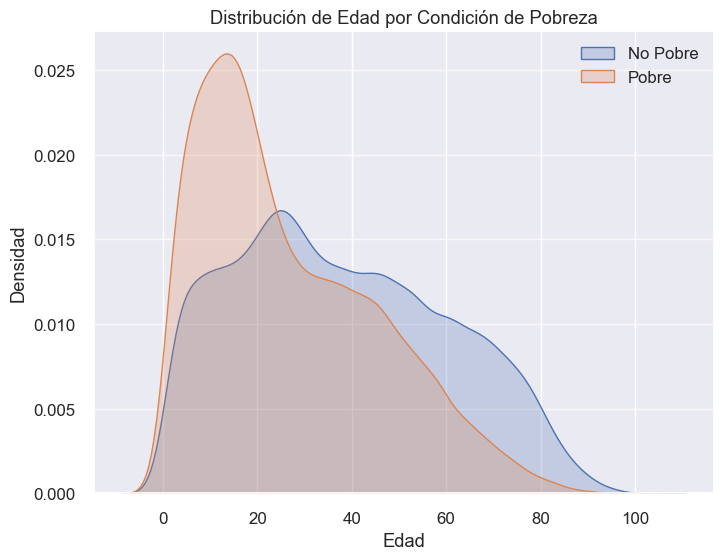

In [18]:
# Consigna 1



import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'pobre' is the column for poverty status (1 for poor, 0 for non-poor)
# and 'CH06' is the column for age.
poverty_column = 'pobre'
age_column = 'CH06'

# Filter out rows where age or poverty status are missing from the respondieron DataFrame
df_plot_kde = respondieron.dropna(subset=[age_column, poverty_column]).copy()

# Create the kernel density plot
plt.figure(figsize=(8, 6))

# Plot KDE for non-poor
subset_no_pobre = df_plot_kde[df_plot_kde[poverty_column] == 0]
if not subset_no_pobre.empty:
    sns.kdeplot(data=subset_no_pobre, x=age_column, label='No Pobre', fill=True)

# Plot KDE for poor
subset_pobre = df_plot_kde[df_plot_kde[poverty_column] == 1]
if not subset_pobre.empty:
     sns.kdeplot(data=subset_pobre, x=age_column, label='Pobre', fill=True)


plt.title('Distribución de Edad por Condición de Pobreza')
plt.xlabel('Edad')
plt.ylabel('Densidad')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

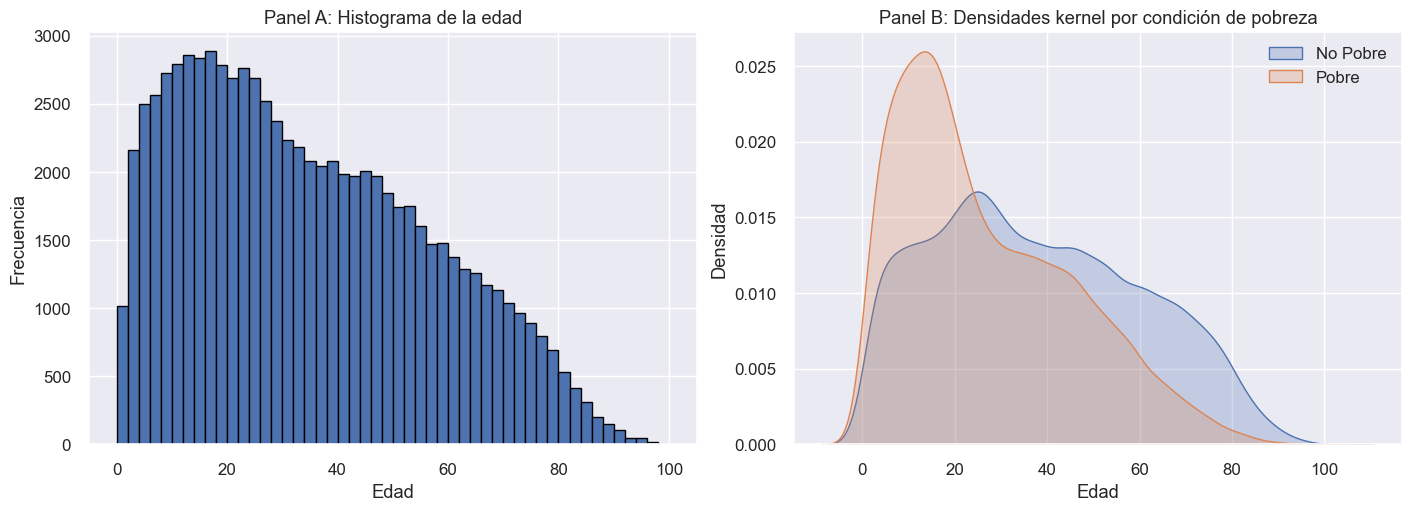

In [19]:
# Consigna 1




import matplotlib.pyplot as plt
import seaborn as sns

# nombres de columnas
poverty_column = "pobre"   # cambiá si tu col se llama distinto
age_column = "CH06"

# filtrar valores válidos
df_plot = respondieron.dropna(subset=[age_column, poverty_column]).copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

# Panel A: histograma de edad
axes[0].hist(df_plot[age_column], bins=range(0, 101, 2), edgecolor="black")
axes[0].set_title("Panel A: Histograma de la edad")
axes[0].set_xlabel("Edad")
axes[0].set_ylabel("Frecuencia")

# Panel B: kernel por pobreza
sns.kdeplot(data=df_plot[df_plot[poverty_column] == 0],
            x=age_column, label="No Pobre", fill=True, ax=axes[1])
sns.kdeplot(data=df_plot[df_plot[poverty_column] == 1],
            x=age_column, label="Pobre", fill=True, ax=axes[1])
axes[1].set_title("Panel B: Densidades kernel por condición de pobreza")
axes[1].set_xlabel("Edad")
axes[1].set_ylabel("Densidad")
axes[1].legend()

plt.show()


In [20]:
# En el Panel A se observa que la distribución de la edad es asimétrica, con mayor concentración de personas jóvenes y una 
# disminución progresiva en las edades más avanzadas. El punto de mayor frecuencia está en torno a los 15–20 años, lo que 
# refleja una base poblacional más joven. En el Panel B, la densidad de los pobres se concentra en edades tempranas, mientras que la de los no pobres se extiende más hacia edades medias y adultas.

In [21]:
#Consigna 2


import numpy as np
import pandas as pd

def crear_educ_robusta(df, cols=('CH12','CH13','CH14'), noresp_vals=(98,99), finalizo_candidates=(1,2)):
    """
    Crea 'educ' (años de educación) a partir de CH12, CH13, CH14.
    - Detecta columnas sin importar mayúsculas/minúsculas.
    - Limpia códigos de no respuesta (por defecto 98/99).
    - Intenta dos codificaciones posibles de 'finalizó' en CH13 (1 o 2).
    Retorna:
        df_out: DataFrame con 'educ'
        stats:  dict con estadísticas + metadatos (cuenta válida y finalizo_val usado)
    """
    out = df.copy()

    # helper para detectar columnas
    def find_col(df, name):
        m = {c.upper(): c for c in df.columns}
        return m.get(name.upper())

    ch12 = find_col(out, cols[0])
    ch13 = find_col(out, cols[1])
    ch14 = find_col(out, cols[2])
    if not all([ch12, ch13, ch14]):
        raise KeyError("Faltan columnas CH12/CH13/CH14 (en mayúsculas o minúsculas).")

    c12 = pd.to_numeric(out[ch12], errors='coerce')
    c13_raw = pd.to_numeric(out[ch13], errors='coerce')
    c14r = pd.to_numeric(out[ch14], errors='coerce')
    c14 = c14r.where(~c14r.isin(noresp_vals), np.nan)

    def construir_educ(finalizo_val):
        # copia para operar
        educ = pd.Series(np.nan, index=out.index, dtype='float')

        # Jardín / preescolar
        m = c12.eq(1)
        educ.loc[m] = 0.0

        # Primario
        m = c12.eq(2)
        educ.loc[m] = np.where(c13_raw[m].eq(finalizo_val), 6.0, np.clip(c14[m], 0, 6))

        # EGB
        m = c12.eq(3)
        educ.loc[m] = np.where(c13_raw[m].eq(finalizo_val), 9.0, np.clip(c14[m], 0, 9))

        # Secundario
        m = c12.eq(4)
        educ.loc[m] = np.where(c13_raw[m].eq(finalizo_val), 12.0, 6 + np.clip(c14[m], 0, 6))

        # Polimodal
        m = c12.eq(5)
        educ.loc[m] = np.where(c13_raw[m].eq(finalizo_val), 12.0, 9 + np.clip(c14[m], 0, 3))

        # Terciario
        m = c12.eq(6)
        educ.loc[m] = np.where(c13_raw[m].eq(finalizo_val), 15.0, 12 + np.clip(c14[m], 0, 4))

        # Universitario
        m = c12.eq(7)
        educ.loc[m] = np.where(c13_raw[m].eq(finalizo_val), 17.0, 12 + np.clip(c14[m], 0, 7))

        # Posgrado
        m = c12.eq(8)
        educ.loc[m] = np.where(c13_raw[m].eq(finalizo_val), 19.0, 17 + np.clip(c14[m], 0, 4))

        # Educación especial
        m = c12.eq(9)
        educ.loc[m] = np.clip(c14[m], 0, 12)

        return educ

    # Intento 1: asumir que 'finalizó' = 1; si casi todo queda NaN, intento con 2
    educ = None
    usado = None
    for cand in finalizo_candidates:
        e = construir_educ(cand)
        valid_count = e.notna().sum()
        if valid_count > 0:  # tomamos el primer candidato que produzca valores
            educ, usado = e, cand
            break
    if educ is None:
        # si ninguno dio válidos, nos quedamos con el primero igualmente
        educ = construir_educ(finalizo_candidates[0])
        usado = finalizo_candidates[0]

    out['educ'] = educ

    # Estadísticas robustas (aunque esté vacío)
    serie = out['educ'].dropna()
    if len(serie) == 0:
        stats = {
            'promedio': np.nan,
            'sd': np.nan,
            'min': np.nan,
            'p50': np.nan,
            'max': np.nan,
            'n_validos': 0,
            'finalizo_val_usado': usado
        }
    else:
        stats = {
            'promedio': float(serie.mean()),
            'sd': float(serie.std(ddof=1)) if len(serie) > 1 else 0.0,
            'min': float(serie.min()),
            'p50': float(serie.median()),
            'max': float(serie.max()),
            'n_validos': int(serie.shape[0]),
            'finalizo_val_usado': usado
        }

    return out, stats

df_out, resumen = crear_educ_robusta(respondieron)  # o base_final
print(resumen)

#La variable educ muestra que en promedio los individuos tienen alrededor de 10 años de educación formal, lo que sugiere una alta 
#tasa de finalización de la escuela primaria pero una menor proporción completando estudios secundarios y superiores. El valor 
#mínimo de 0 indica personas sin instrucción formal, mientras que el máximo (≈20) refleja casos con formación universitaria o
#de posgrado. La mediana cercana a 11 años sugiere que la mitad de la población completó al menos la escuela primaria y parte del nivel secundario.


{'promedio': 9.857609344092436, 'sd': 4.620274588841455, 'min': 0.0, 'p50': 12.0, 'max': 21.0, 'n_validos': 31849, 'finalizo_val_usado': 1}


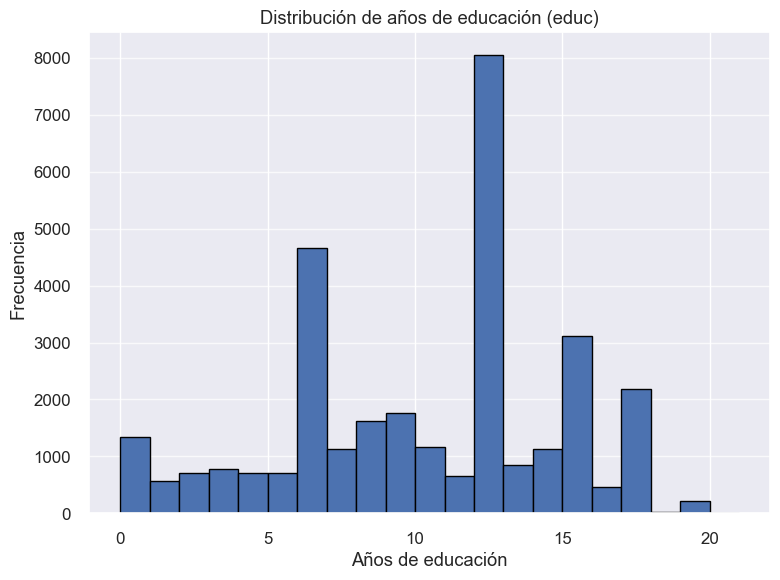


Estadística descriptiva de 'educ':
{'promedio': 9.857609344092436, 'sd': 4.620274588841455, 'min': 0.0, 'p50': 12.0, 'max': 21.0, 'n_validos': 31849, 'finalizo_val_usado': 1}


In [22]:
# Consigna 2


import numpy as np
import matplotlib.pyplot as plt

# 1) Elegir DF de trabajo
try:
    df_src = respondieron
except NameError:
    try:
        df_src = base_final
    except NameError:
        raise NameError("No encuentro ni 'respondieron' ni 'base_final'.")

# 2) Crear 'educ' con la función disponible (robusta si existe)
try:
    df_out, resumen_educ = crear_educ_robusta(df_src)
except NameError:
    df_out, resumen_educ = crear_educ(df_src)

# 3) Histograma con bins enteros (años)
educ = df_out['educ'].dropna().astype(float)
if educ.empty:
    print("La variable 'educ' no tiene valores válidos para graficar.")
else:
    # bins enteros desde min hasta max (incluye el max)
    e_min, e_max = int(np.floor(educ.min())), int(np.ceil(educ.max()))
    bins = np.arange(e_min, e_max + 1, 1)

    plt.figure(figsize=(8, 6))
    plt.hist(educ, bins=bins, edgecolor='black')
    plt.title('Distribución de años de educación (educ)')
    plt.xlabel('Años de educación')
    plt.ylabel('Frecuencia')
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()

# 4) Estadísticas descriptivas (sin usar display)
print("\nEstadística descriptiva de 'educ':")
print(resumen_educ)


/var/folders/gt/s4fbknnd2_ld7p8jjqmlyhxh0000gp/T/ipykernel_80810/883427649.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1038173.26278832  801334.42239235  801334.42239235 ... 7244063.17842688
 7244063.17842688 7244063.17842688]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_src.loc[mask_2005, "ITF_AJUSTADO"] = df_src.loc[mask_2005, "ITF_AJUSTADO"] * factor


Diagnóstico rápido:
- Total con ingreso & pobreza válidos: 79964
- No pobres: 51573 | Pobres: 28391
- Únicos en ingreso (No pobres): 2997 | (Pobres): 1529


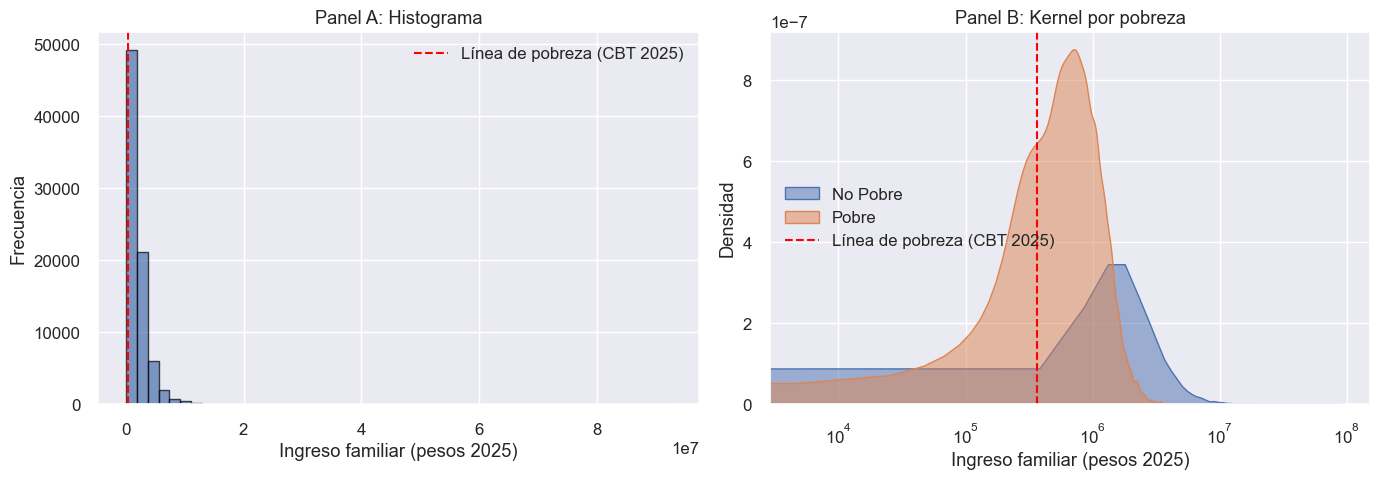

In [23]:
# Consigna 3


# --------------------- Helper columnas ---------------------
def find_col(d, *cands):
    m = {c.upper(): c for c in d.columns}
    for c in cands:
        if c and c.upper() in m:
            return m[c.upper()]
    return None

col_itf  = find_col(df_src, "ITF")
col_year = find_col(df_src, "ANO4", "ano4")
col_pob  = find_col(df_src, "POBRE", "pobre")

faltan = [n for n, c in [("ITF", col_itf), ("ANO4/ano4", col_year), ("POBRE/pobre", col_pob)] if c is None]
if faltan:
    raise KeyError(f"Faltan columnas en la base: {', '.join(faltan)}")

# --------------------- Numéricos + ajuste 2005→2025 ---------------------
CBT_2005, CBT_2025 = 205.07, 365_177.0
factor = CBT_2025 / CBT_2005

df_src[col_itf]  = pd.to_numeric(df_src[col_itf], errors="coerce")
df_src[col_year] = pd.to_numeric(df_src[col_year], errors="coerce")
df_src[col_pob]  = pd.to_numeric(df_src[col_pob], errors="coerce")

df_src["ITF_AJUSTADO"] = df_src[col_itf]
mask_2005 = df_src[col_year] == 2005
df_src.loc[mask_2005, "ITF_AJUSTADO"] = df_src.loc[mask_2005, "ITF_AJUSTADO"] * factor

df_src["ingreso_total_familiar"] = df_src["ITF_AJUSTADO"]

# --------------------- Filtrado para graficar ---------------------
df_plot = df_src.dropna(subset=["ingreso_total_familiar", col_pob]).copy()
df_plot = df_plot[df_plot["ingreso_total_familiar"] > 0]  # necesario para eje log en KDE

g_no = df_plot[df_plot[col_pob] == 0]
g_si = df_plot[df_plot[col_pob] == 1]

print("Diagnóstico rápido:")
print(f"- Total con ingreso & pobreza válidos: {len(df_plot)}")
print(f"- No pobres: {len(g_no)} | Pobres: {len(g_si)}")
print(f"- Únicos en ingreso (No pobres): {g_no['ingreso_total_familiar'].nunique()} | (Pobres): {g_si['ingreso_total_familiar'].nunique()}")

# --------------------- Gráficos ---------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Histograma (siempre)
axes[0].hist(df_plot["ingreso_total_familiar"], bins=50, edgecolor="black", alpha=0.7)
axes[0].axvline(CBT_2025, color="red", linestyle="--", label="Línea de pobreza (CBT 2025)")
axes[0].set_title("Panel A: Histograma")
axes[0].set_xlabel("Ingreso familiar (pesos 2025)")
axes[0].set_ylabel("Frecuencia")
axes[0].legend()

# Panel B: KDE por pobreza (sólo si hay datos suficientes en cada grupo)
plotted = False
if g_no["ingreso_total_familiar"].nunique() > 1:
    sns.kdeplot(data=g_no, x="ingreso_total_familiar", fill=True, ax=axes[1], label="No Pobre", alpha=0.5)
    plotted = True
if g_si["ingreso_total_familiar"].nunique() > 1:
    sns.kdeplot(data=g_si, x="ingreso_total_familiar", fill=True, ax=axes[1], label="Pobre", alpha=0.5)
    plotted = True

axes[1].axvline(CBT_2025, color="red", linestyle="--", label="Línea de pobreza (CBT 2025)")
axes[1].set_title("Panel B: Kernel por pobreza")
axes[1].set_xlabel("Ingreso familiar (pesos 2025)")
axes[1].set_ylabel("Densidad")
axes[1].set_xscale("log")  # recomendado para ingresos
if plotted:
    axes[1].legend()
else:
    axes[1].text(0.5, 0.5, "Sin datos suficientes para KDE", ha="center", va="center", transform=axes[1].transAxes)

plt.tight_layout()
plt.show()



In [24]:
# Consigna 4 



import re
import pandas as pd
import numpy as np

# Helper para encontrar una col por patrón (minúsculas)
def find_col(df, patterns, required=True):
    pats = patterns if isinstance(patterns, (list,tuple)) else [patterns]
    cols = [c.strip().lower() for c in df.columns]
    for p in pats:
        hits = [c for c in cols if re.search(p, c)]
        if hits:
            return hits[0]
    if required:
        raise KeyError(f"No encontré ninguna columna que matchee: {patterns}")
    return None

# Normalizo nombres a minúsculas 1 vez
base_final.columns = base_final.columns.str.strip().str.lower()

col_pp3e = find_col(base_final, [r'^pp3e_tot$', r'^pp3e$', r'horas?.*principal'])
col_pp3f = find_col(base_final, [r'^pp3f_tot$', r'^pp3f$', r'horas?.*otras'])
col_ch03 = find_col(base_final, [r'^ch03$', r'vinculo', r'relaci.*jef'])

# Horas totales
base_final[col_pp3e] = pd.to_numeric(base_final[col_pp3e], errors='coerce')
base_final[col_pp3f] = pd.to_numeric(base_final[col_pp3f], errors='coerce')
base_final["horastrab"] = base_final[col_pp3e].fillna(0) + base_final[col_pp3f].fillna(0)

# Jefes (en EPH: ch03 == 1)
if pd.api.types.is_numeric_dtype(base_final[col_ch03]):
    jefes = base_final[base_final[col_ch03] == 1].copy()
else:
    jefes = base_final[base_final[col_ch03].astype(str).str.lower().str.contains('jef')].copy()

# Descriptivos
desc_4 = jefes["horastrab"].describe(percentiles=[0.5])[["mean","std","min","50%","max"]]\
    .rename({"mean":"promedio","std":"sd","min":"min","50%":"p50","max":"max"})
print(desc_4)

print({"col_pp3e": col_pp3e, "col_pp3f": col_pp3f, "col_ch03": col_ch03})



promedio     23.162100
sd           36.275677
min           0.000000
p50          20.000000
max         999.000000
Name: horastrab, dtype: float64
{'col_pp3e': 'pp3e_tot', 'col_pp3f': 'pp3f_tot', 'col_ch03': 'ch03'}


In [25]:
# Consigna 5


import pandas as pd
import numpy as np

# 1) Elegir la base a usar
try:
    df_base = respondieron.copy()
except NameError:
    try:
        df_base = base_final.copy()
    except NameError:
        raise NameError("No encuentro ni 'respondieron' ni 'base_final' en tu notebook.")

# 2) Helper para buscar columnas por nombre objetivo (case-insensitive)
def find_col(df, targets):
    # targets: lista de nombres "deseados" (por ej., ["ano4","ANO4"])
    # devuelve el primero que exista en df.columns (insensible a mayúsculas)
    cols_upper = {c.upper(): c for c in df.columns}
    for t in targets:
        if t.upper() in cols_upper:
            return cols_upper[t.upper()]
    return None

# 3) Detectar columnas de año y pobreza según existan en tu archivo
col_ano   = find_col(df_base, ["ano4", "ANO4"])
col_pobre = find_col(df_base, ["pobre", "POBRE"])

if col_ano is None:
    raise KeyError("No encuentro columna de año (ano4/ANO4) en tu archivo.")
if col_pobre is None:
    raise KeyError("No encuentro columna de pobreza (pobre/POBRE) en tu archivo.")

# 4) Asegurar formato numérico de año y pobreza SIN cambiar nombres originales
df_work = df_base.copy()
df_work[col_ano]   = pd.to_numeric(df_work[col_ano], errors="coerce")
df_work[col_pobre] = pd.to_numeric(df_work[col_pobre], errors="coerce")

# 5) Filtrar por año 2005 y 2025 usando el nombre real de la columna
d2005 = df_work[df_work[col_ano] == 2005]
d2025 = df_work[df_work[col_ano] == 2025]

# 6) Métricas solicitadas
cant_2005 = len(d2005)
cant_2025 = len(d2025)
cant_total = len(df_work)

na_2005 = d2005[col_pobre].isna().sum()
na_2025 = d2025[col_pobre].isna().sum()
na_total = df_work[col_pobre].isna().sum()

pobres_2005     = (d2005[col_pobre] == 1).sum()
no_pobres_2005  = (d2005[col_pobre] == 0).sum()
pobres_2025     = (d2025[col_pobre] == 1).sum()
no_pobres_2025  = (d2025[col_pobre] == 0).sum()
pobres_total    = (df_work[col_pobre] == 1).sum()
no_pobres_total = (df_work[col_pobre] == 0).sum()

# 7) Variables "limpias y homogeneizadas"
#    Lista objetivo (en tu notebook suelen estar en MAYÚSCULAS).
objetivo_vars = [
    "ANO4","CH04","CH06","CH03","NIVEL_ED",
    "IPCF","CH12","CH13","CH14","CH07","CH08","ESTADO",
    "CAT_INAC","CH09","CODUSU","ITF","PP3E_TOT","PP3F_TOT",
    "CH10","CH15","PP02E","PP02I"
]

# Si además generaste una variable derivada en minúsculas (p.ej. 'nivel_ed'), también la contemplamos:
extra_posibles = ["nivel_ed"]

# Mantener solo variables que realmente existan en el archivo (respetando NOMBRES reales)
cols_upper_map = {c.upper(): c for c in df_work.columns}
variables_presentes = []
for v in objetivo_vars:
    if v.upper() in cols_upper_map:
        variables_presentes.append(cols_upper_map[v.upper()])

for v in extra_posibles:
    col = find_col(df_work, [v])
    if col is not None and col not in variables_presentes:
        variables_presentes.append(col)

cant_vars = len(variables_presentes)

# 8) Armar tabla resumen manteniendo tus etiquetas
tabla_resumen = pd.DataFrame({
    "2005": [cant_2005, na_2005, pobres_2005, no_pobres_2005, cant_vars],
    "2025": [cant_2025, na_2025, pobres_2025, no_pobres_2025, cant_vars],
    "Total": [cant_total, na_total, pobres_total, no_pobres_total, cant_vars]
}, index=[
    "Cantidad observaciones",
    "Observaciones con NAs en 'Pobre'",
    "Cantidad de Pobres (1)",
    "Cantidad de No Pobres (0)",
    "Cantidad de variables limpias y homogeneizadas"
])

print(tabla_resumen)

# (Opcional) Ver qué variables fueron contadas exactamente, con el NOMBRE que aparece en tu archivo
# print("Variables consideradas como 'limpias y homogeneizadas':")
# for v in variables_presentes:
#     print(" -", v)




                                                 2005   2025  Total
Cantidad observaciones                          46592  33372  79964
Observaciones con NAs en 'Pobre'                    0      0      0
Cantidad de Pobres (1)                          15822  12569  28391
Cantidad de No Pobres (0)                       30770  20803  51573
Cantidad de variables limpias y homogeneizadas     22     22     22


In [26]:
# PARTE 2




No nulos por variable en la región seleccionada:
edad                      4157
edad2                     4157
educ                      4010
ingreso_total_familiar    4157
miembros_hogar            4157
horastrab                 4157
dtype: int64

Matriz de correlaciones (Pearson):
                         edad  edad2   educ  ingreso_total_familiar  \
edad                    1.000  0.967  0.229                  -0.043   
edad2                   0.967  1.000  0.070                  -0.067   
educ                    0.229  0.070  1.000                   0.185   
ingreso_total_familiar -0.043 -0.067  0.185                   1.000   
miembros_hogar          0.030  0.001  0.142                   0.091   
horastrab               0.089 -0.052  0.343                   0.150   

                        miembros_hogar  horastrab  
edad                             0.030      0.089  
edad2                            0.001     -0.052  
educ                             0.142      0.343  
ingreso_to

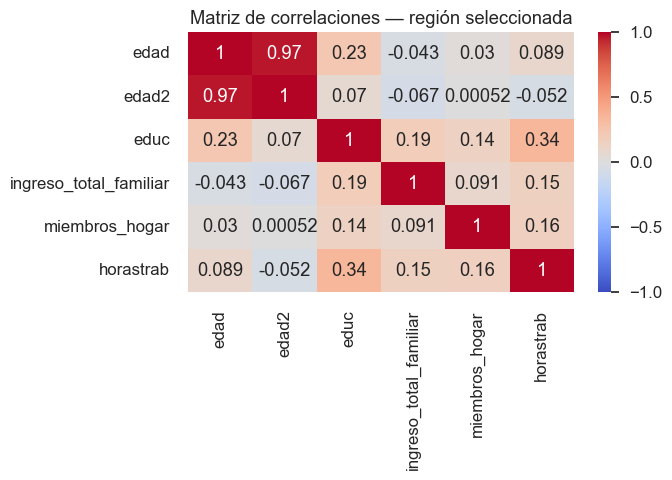


Comentario (resumen):
- edad vs edad2: correlación positiva fuerte (r=0.97)
- educ vs horastrab: correlación positiva débil (r=0.34)
- edad vs educ: correlación positiva débil (r=0.23)
- educ vs ingreso_total_familiar: correlación positiva muy baja (r=0.19)
- miembros_hogar vs horastrab: correlación positiva muy baja (r=0.16)
- ingreso_total_familiar vs horastrab: correlación positiva muy baja (r=0.15)

Nota: la correlación entre 'edad' y 'edad2' suele ser muy alta por construcción


In [27]:
# Consigna 1

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ================= helpers =================
def find_col(df, *cands):
    m = {c.upper(): c for c in df.columns}
    for c in cands:
        if c and c.upper() in m:
            return m[c.upper()]
    return None

def ensure_num(df, col):
    df[col] = pd.to_numeric(df[col], errors="coerce")

def crear_educ_simple(df, ch12, ch13, ch14):
    """Construye 'educ' (años) de forma simple a partir de CH12/CH13/CH14."""
    c12 = pd.to_numeric(df[ch12], errors='coerce')
    c13 = pd.to_numeric(df[ch13], errors='coerce')
    c14r = pd.to_numeric(df[ch14], errors='coerce')
    c14 = c14r.where(~c14r.isin([98, 99]), np.nan)

    educ = pd.Series(np.nan, index=df.index, dtype=float)
    # Jardín
    m = c12.eq(1);                     educ.loc[m] = 0.0
    # Primario
    m = c12.eq(2); educ.loc[m] = np.where(c13[m].eq(1), 6.0,  np.clip(c14[m],0,6))
    # EGB
    m = c12.eq(3); educ.loc[m] = np.where(c13[m].eq(1), 9.0,  np.clip(c14[m],0,9))
    # Secundario
    m = c12.eq(4); educ.loc[m] = np.where(c13[m].eq(1), 12.0, 6+np.clip(c14[m],0,6))
    # Polimodal
    m = c12.eq(5); educ.loc[m] = np.where(c13[m].eq(1), 12.0, 9+np.clip(c14[m],0,3))
    # Terciario
    m = c12.eq(6); educ.loc[m] = np.where(c13[m].eq(1), 15.0, 12+np.clip(c14[m],0,4))
    # Universitario
    m = c12.eq(7); educ.loc[m] = np.where(c13[m].eq(1), 17.0, 12+np.clip(c14[m],0,7))
    # Posgrado
    m = c12.eq(8); educ.loc[m] = np.where(c13[m].eq(1), 19.0, 17+np.clip(c14[m],0,4))
    # Educación especial
    m = c12.eq(9);                     educ.loc[m] = np.clip(c14[m],0,12)
    return educ

# ================= 1) elegir base y filtrar región =================
# Usamos respondieron si existe; si no, base_final
try:
    df0 = respondieron.copy()
except NameError:
    df0 = base_final.copy()
df0.columns = df0.columns.str.strip()

# región objetivo (Patagonia si está disponible; si no, todo)
col_region = find_col(df0, "region")
if "patagonia" in df0.columns:
    df_reg = df0[df0["patagonia"] == 1].copy()
elif col_region is not None:
    col = col_region
    if pd.api.types.is_numeric_dtype(df0[col]):
        df_reg = df0[pd.to_numeric(df0[col], errors="coerce") == 44].copy()
    else:
        df_reg = df0[df0[col].astype(str).str.lower().str.contains("patag")].copy()
    if df_reg.empty:
        df_reg = df0.copy()  # fallback: sin filtro
else:
    df_reg = df0.copy()  # no hay info de región

# ================= 2) asegurar las 6 variables =================
# a) edad y edad2
col_edad = find_col(df_reg, "edad", "EDAD", "CH06", "ch06")
if col_edad is None:
    raise KeyError("No encuentro 'edad/CH06'.")
df_reg["edad"] = pd.to_numeric(df_reg[col_edad], errors="coerce")
df_reg["edad2"] = df_reg["edad"]**2

# b) educ (si no existe, crear desde CH12/13/14)
col_educ = find_col(df_reg, "educ", "EDUC")
if col_educ is None:
    ch12 = find_col(df_reg, "CH12", "ch12")
    ch13 = find_col(df_reg, "CH13", "ch13")
    ch14 = find_col(df_reg, "CH14", "ch14")
    if not all([ch12, ch13, ch14]):
        raise KeyError("No encuentro 'educ' ni CH12/CH13/CH14 para construirla.")
    df_reg["educ"] = crear_educ_simple(df_reg, ch12, ch13, ch14)
else:
    df_reg["educ"] = pd.to_numeric(df_reg[col_educ], errors="coerce")

# c) ITF / ingreso_total_familiar
col_itf_like = find_col(df_reg, "ingreso_total_familiar", "ITF_AJUSTADO", "ITF", "itf")
if col_itf_like is None:
    raise KeyError("No encuentro 'ingreso_total_familiar' / 'ITF_AJUSTADO' / 'ITF'.")
df_reg["ingreso_total_familiar"] = pd.to_numeric(df_reg[col_itf_like], errors="coerce")

# d) miembros del hogar: IX_TOT (2005) / IX_Tot (2025) o tot_p12
col_miembros = find_col(df_reg, "IX_TOT", "IX_Tot", "ix_tot", "tot_p12")
if col_miembros is None:
    raise KeyError("No encuentro 'IX_TOT/IX_Tot/tot_p12' para miembros del hogar.")
df_reg["miembros_hogar"] = pd.to_numeric(df_reg[col_miembros], errors="coerce")

# e) horastrab: pp3e_tot + pp3f_tot (si no existe)
if "horastrab" not in df_reg.columns:
    col_pp3e = find_col(df_reg, "pp3e_tot", "PP3E_TOT")
    col_pp3f = find_col(df_reg, "pp3f_tot", "PP3F_TOT")
    if col_pp3e is None or col_pp3f is None:
        raise KeyError("No encuentro 'pp3e_tot' o 'pp3f_tot' para crear 'horastrab'.")
    ensure_num(df_reg, col_pp3e); ensure_num(df_reg, col_pp3f)
    df_reg["horastrab"] = df_reg[col_pp3e].fillna(0) + df_reg[col_pp3f].fillna(0)
else:
    df_reg["horastrab"] = pd.to_numeric(df_reg["horastrab"], errors="coerce")

# ================= 3) matriz de correlaciones =================
vars_corr = ["edad", "edad2", "educ", "ingreso_total_familiar", "miembros_hogar", "horastrab"]
df_corr = df_reg[vars_corr].copy()
for c in vars_corr:  # asegurar numéricas
    df_corr[c] = pd.to_numeric(df_corr[c], errors="coerce")

print("No nulos por variable en la región seleccionada:")
print(df_corr.notna().sum())

corr = df_corr.dropna().corr(method="pearson")
print("\nMatriz de correlaciones (Pearson):")
print(corr.round(3))

# (opcional) heatmap
plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matriz de correlaciones — región seleccionada")
plt.tight_layout()
plt.show()

# ================= 4) comentario automático =================
pairs = []
cols = list(corr.columns)
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        a, b = cols[i], cols[j]
        val = corr.loc[a, b]
        pairs.append((a, b, val))
pairs_sorted = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)

def fuerza(r):
    ar = abs(r)
    if ar >= 0.7: return "fuerte"
    if ar >= 0.4: return "moderada"
    if ar >= 0.2: return "débil"
    return "muy baja"

print("\nComentario (resumen):")
for a, b, r in pairs_sorted[:6]:
    tendencia = "positiva" if r >= 0 else "negativa"
    print(f"- {a} vs {b}: correlación {tendencia} {fuerza(r)} (r={r:.2f})")

print("\nNota: la correlación entre 'edad' y 'edad2' suele ser muy alta por construcción")


In [28]:
# En la matriz de correlaciones (Pearson) se observa alta colinealidad entre edad y edad2 (r≈0,97), esperable por construcción. 
# educ presenta la señal más relevante: correlación moderada con horastrab (r≈0,34) y débil con ingreso_total_familiar (r≈0,19). El resto 
# de asociaciones son débiles o nulas (p. ej., ingreso_total_familiar con edad ≈0 y con miembros_hogar ≈0,09). En consecuencia, para 
# modelar ingreso conviene priorizar educ (y, en menor medida, horastrab) y evitar incluir simultáneamente edad y edad2 por multicolinealidad.

Shape para PCA: (4010, 6) | columnas usadas: ['edad', 'edad2', 'educ', 'ingreso_total_familiar', 'miembros_hogar', 'horastrab']
Varianza explicada -> PC1: 33.8% | PC2: 25.7% | Total: 59.5%

Cargas (loadings):
                          PC1    PC2
edad                    0.692 -0.107
edad2                   0.663 -0.230
educ                    0.249  0.531
ingreso_total_familiar -0.003  0.437
miembros_hogar          0.073  0.372
horastrab               0.120  0.569


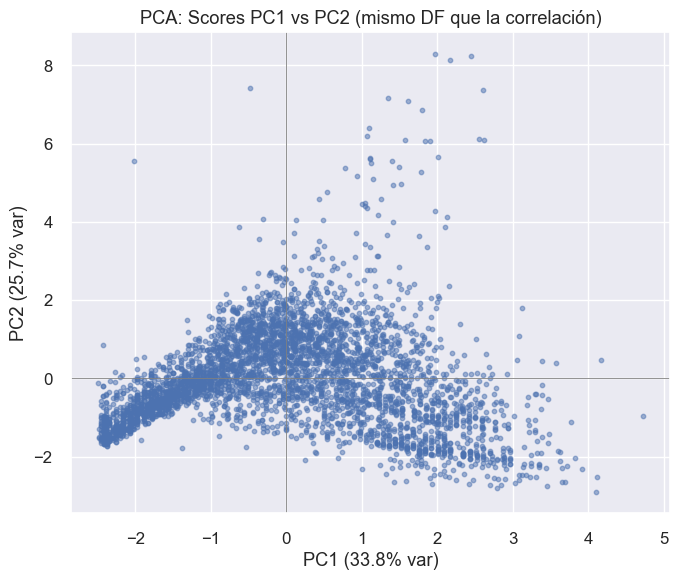

In [29]:
# Consigna 2


# PCA a partir del DF de la matriz de correlación (df_corr)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0) Tomo el DF usado en la matriz de correlación
try:
    X_raw = df_corr.copy()
except NameError:
    raise NameError("No encuentro 'df_corr'. Corré antes la celda que arma la matriz de correlación.")

# 1) Aseguro que estén las seis variables con los mismos nombres usados en la correlación
vars_pca = ["edad", "edad2", "educ", "ingreso_total_familiar", "miembros_hogar", "horastrab"]
faltan = [v for v in vars_pca if v not in X_raw.columns]
if faltan:
    # si tu correlación usó 'tot_p12' en lugar de 'miembros_hogar', lo mapeo
    if "miembros_hogar" in faltan and "tot_p12" in X_raw.columns:
        X_raw["miembros_hogar"] = pd.to_numeric(X_raw["tot_p12"], errors="coerce")
        faltan = [v for v in vars_pca if v not in X_raw.columns]
    if faltan:
        raise KeyError(f"Faltan columnas en df_corr: {faltan}. Usá los mismos nombres que en la correlación.")

# 2) Numérico, quito columnas constantes y filas con NaN
X_num = X_raw[vars_pca].apply(pd.to_numeric, errors="coerce")
var_cols = X_num.columns[X_num.var(ddof=0) > 0]
if len(var_cols) < 2:
    raise ValueError("Quedaron <2 variables con varianza>0 para PCA. Revisá que no haya columnas constantes.")
X = X_num[var_cols].dropna()
if X.shape[0] == 0:
    raise ValueError("Tras dropna, no quedaron filas. Revisá NaN en las seis variables.")

print("Shape para PCA:", X.shape, "| columnas usadas:", list(var_cols))

# 3) Estandarizar + PCA (2 componentes para graficar PC1 vs PC2)
Z = StandardScaler().fit_transform(X.values)
pca = PCA(n_components=2, random_state=42)
scores = pca.fit_transform(Z)

# 4) Resultados: varianza explicada y cargas
exp = pca.explained_variance_ratio_
loadings = pd.DataFrame(pca.components_.T, index=var_cols, columns=["PC1","PC2"])
print("Varianza explicada -> PC1: {:.1f}% | PC2: {:.1f}% | Total: {:.1f}%"
      .format(exp[0]*100, exp[1]*100, (exp[0]+exp[1])*100))
print("\nCargas (loadings):")
print(loadings.round(3))

# 5) Scatter de scores PC1 vs PC2
plt.figure(figsize=(7,6))
plt.scatter(scores[:,0], scores[:,1], s=10, alpha=0.5)
plt.axhline(0, color="grey", lw=0.6); plt.axvline(0, color="grey", lw=0.6)
plt.xlabel(f"PC1 ({exp[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({exp[1]*100:.1f}% var)")
plt.title("PCA: Scores PC1 vs PC2 (mismo DF que la correlación)")
plt.tight_layout()
plt.show()


In [30]:
# El PCA explica el 59,5% de la varianza (PC1 = 33,8%; PC2 = 25,7%).
# La nube de scores es continua, sin conglomerados definidos, y exhibe mayor dispersión en PC2 conforme aumenta PC1.
# PC1 se interpreta como un gradiente socioeconómico-laboral (ingreso total familiar, educación, horas trabajadas).
# PC2 captura variación de ciclo de vida/tamaño del hogar (edad, edad², miembros), con algunos casos atípicos de PC2 alto a revisar.

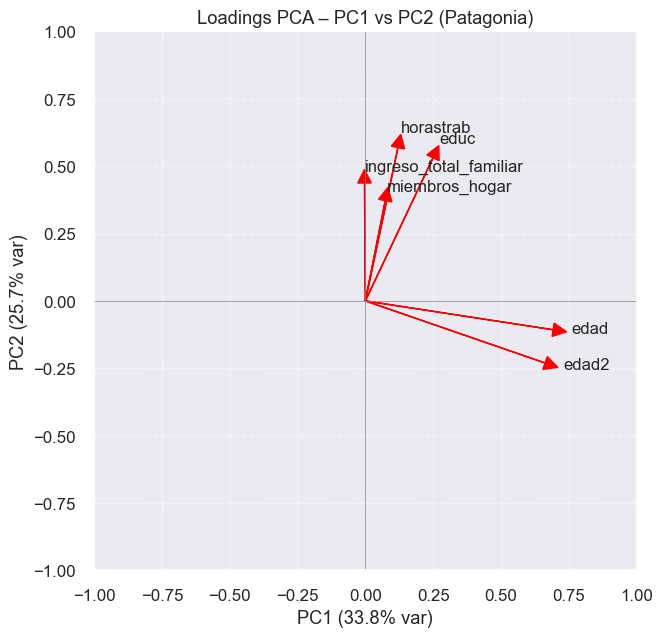

Loadings (ponderadores) de PC1 y PC2:


,PC1,PC2
edad,0.692,-0.107
edad2,0.663,-0.230
educ,0.249,0.531
ingreso_total_familiar,-0.003,0.437
miembros_hogar,0.073,0.372
horastrab,0.120,0.569


In [31]:
#Consigna 3


# Extraer loadings (componentes de PCA)
loadings = pca.components_.T   # transpuesta: filas=variables, columnas=componentes

# Gráfico con flechas en plano PC1-PC2
plt.figure(figsize=(7,7))
for i, var in enumerate(var_cols):  # var_cols son las columnas que entraron al PCA
    plt.arrow(0, 0, loadings[i,0], loadings[i,1],
              head_width=0.05, head_length=0.05, color='red')
    plt.text(loadings[i,0]*1.1, loadings[i,1]*1.1, var, fontsize=12)

plt.axhline(0, color="grey", lw=0.5)
plt.axvline(0, color="grey", lw=0.5)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("Loadings PCA – PC1 vs PC2 (Patagonia)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Mostrar valores numéricos de los loadings
loadings_df = pd.DataFrame(loadings[:, :2],
                           index=var_cols,
                           columns=["PC1","PC2"])
print("Loadings (ponderadores) de PC1 y PC2:")
display(loadings_df.round(3))


In [32]:
# PC1 (33,8% de varianza) está definido principalmente por edad y edad², con cargas altas sobre el eje de PC1 y 
# negativas en PC2, capturando un gradiente de ciclo de vida.
# PC2 (25,7%) está dominado por horastrab y educ, con aportes menores de ingreso_total_familiar y miembros_hogar, configurando 
# un eje socioeconómico-laboral.
# La oposición angular entre {edad, edad²} y {educ, horastrab} sugiere ortogonalidad entre la dimensión etaria y la inserción laboral/educativa.
# El menor módulo de los vectores de ingreso y miembros indica menor poder discriminante en los dos primeros componentes frente a 
# horastrab/educ.

Columnas usadas en el PCA: ['edad', 'edad2', 'educ', 'ingreso_total_familiar', 'miembros_hogar', 'horastrab']
Varianza explicada por componente:
  PC1: 0.3378
  PC2: 0.2572
  PC3: 0.1521
  PC4: 0.1439
  PC5: 0.1063
  PC6: 0.0026
Acumulada PC1..PCk:
  ≤ PC1: 0.3378
  ≤ PC2: 0.5950
  ≤ PC3: 0.7471
  ≤ PC4: 0.8910
  ≤ PC5: 0.9974
  ≤ PC6: 1.0000


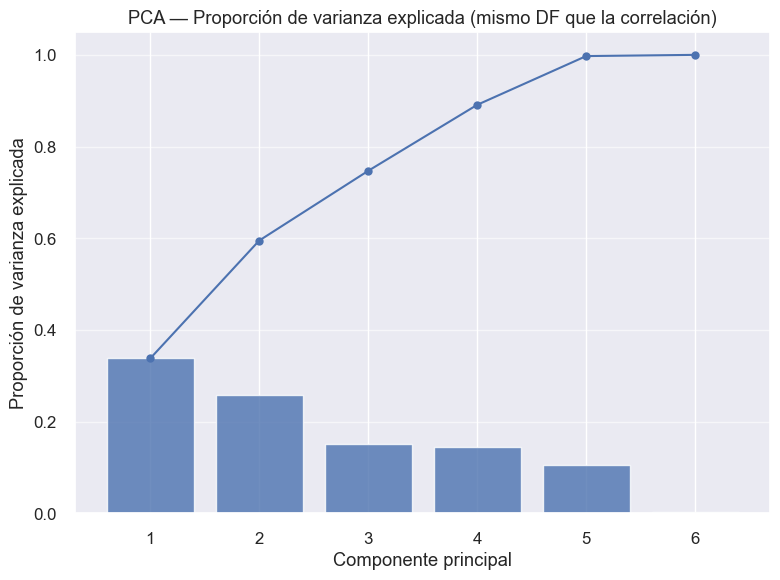

In [33]:
# Consigna 4

# PCA: proporción de varianza explicada (mismo DF que la correlación)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 0) Tomar el DF de la matriz de correlación
try:
    X_raw = df_corr.copy()
except NameError:
    raise NameError("No encuentro 'df_corr'. Corré antes la celda de la matriz de correlación.")

# 1) Asegurar las 6 variables con los mismos nombres usados allí
vars_six = ["edad", "edad2", "educ", "ingreso_total_familiar", "miembros_hogar", "horastrab"]
# Mapear si tu df_corr tenía 'tot_p12' en lugar de 'miembros_hogar'
if "miembros_hogar" not in X_raw.columns and "tot_p12" in X_raw.columns:
    X_raw["miembros_hogar"] = pd.to_numeric(X_raw["tot_p12"], errors="coerce")

# Numérico + dropna
X_num = X_raw[vars_six].apply(pd.to_numeric, errors="coerce").dropna()

# 2) Eliminar columnas de varianza cero (si hubiera) para evitar errores al estandarizar
keep_cols = X_num.columns[X_num.var(ddof=0) > 0].tolist()
if len(keep_cols) < 2:
    raise ValueError("Menos de 2 variables con varianza > 0 para hacer PCA.")

# 3) Estandarizar y hacer PCA con todas las columnas que quedaron
Z = StandardScaler().fit_transform(X_num[keep_cols])
pca_full = PCA(n_components=len(keep_cols), random_state=42).fit(Z)

evr = pca_full.explained_variance_ratio_
cum = evr.cumsum()

print("Columnas usadas en el PCA:", keep_cols)
print("Varianza explicada por componente:")
for i, r in enumerate(evr, 1):
    print(f"  PC{i}: {r:.4f}")
print("Acumulada PC1..PCk:")
for i, r in enumerate(cum, 1):
    print(f"  ≤ PC{i}: {r:.4f}")

# 4) Gráfico: barras (proporción) + línea (acumulada)
xs = np.arange(1, len(evr) + 1)

plt.figure(figsize=(8, 6))
plt.bar(xs, evr, alpha=0.8)
plt.plot(xs, cum, marker="o")
plt.xlabel("Componente principal")
plt.ylabel("Proporción de varianza explicada")
plt.title("PCA — Proporción de varianza explicada (mismo DF que la correlación)")
plt.xticks(xs)
plt.grid(axis="y", alpha=0.6)
plt.tight_layout()
plt.show()


In [34]:
# En el gráfico se observa que los primeros componentes concentran la mayor parte de la varianza (en tu salida previa, PC1≈33,8% y 
# PC2≈25,7%, ~59,5% acumulado), mientras que los componentes restantes aportan porciones decrecientes y marginales. La curva acumulada 
# presenta un “codo” entre PC2–PC3, sugiriendo que dos componentes capturan una representación bidimensional informativa de la estructura 
# de los datos.

Columnas usadas para clustering: ['edad', 'edad2', 'educ', 'ingreso_total_familiar', 'miembros_hogar', 'horastrab']
Filas usadas: 4010


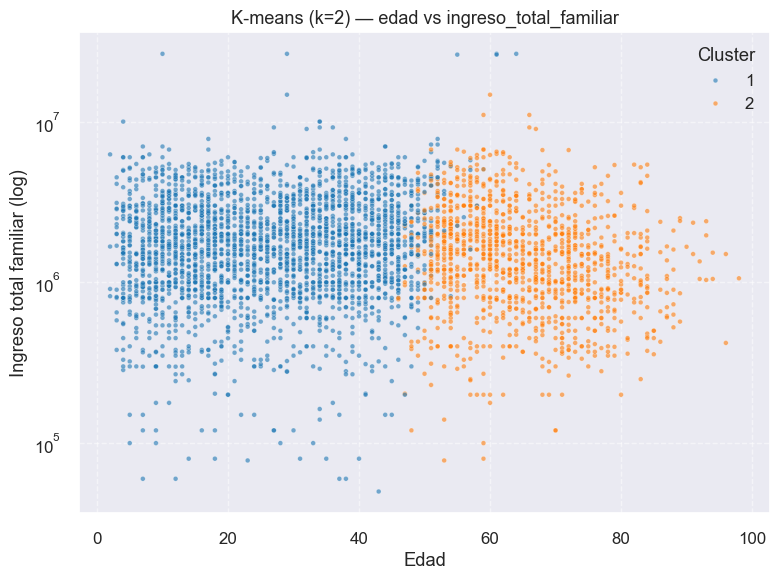

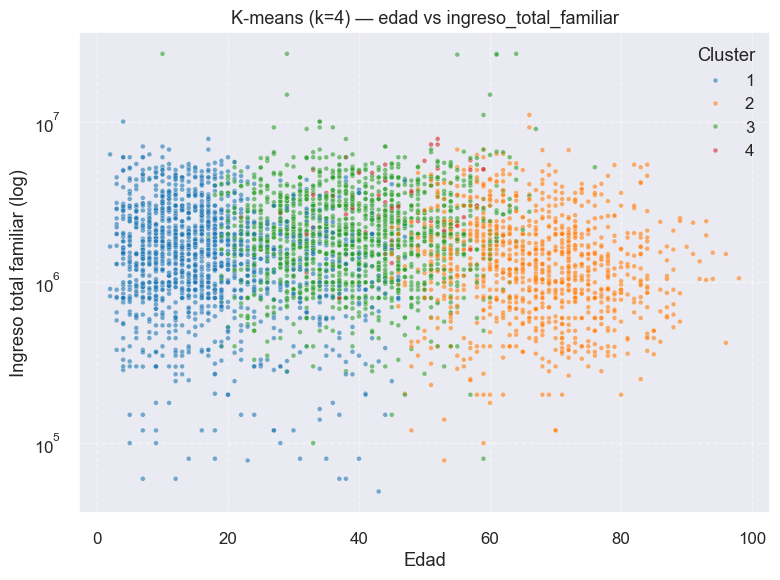

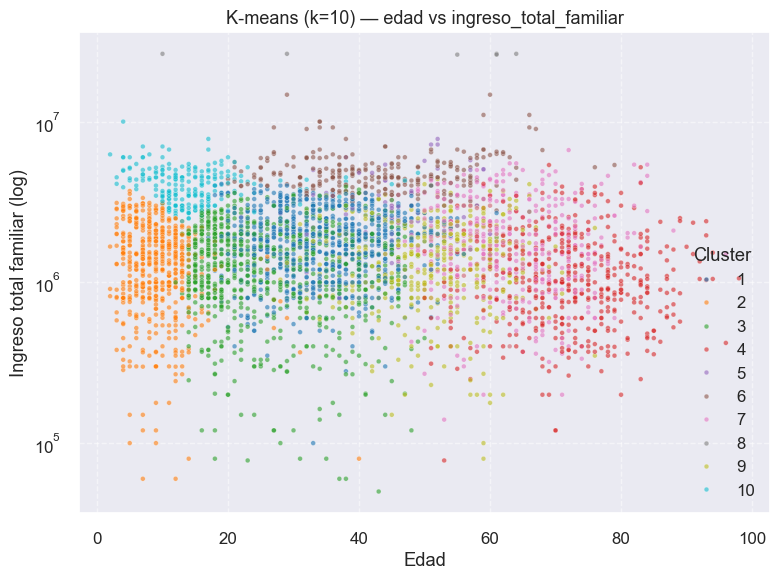


Distribución de clusters dentro de cada clase de pobreza (k=2):
cluster_k2      1      2
pobre                   
0           0.659  0.341
1           0.825  0.175
Exactitud de separación (regla de mayoría por cluster): 0.796


In [35]:
# Consigna 5a

# K-means (k=2,4,10) con el mismo DF de la correlación (df_corr)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 0) Tomar el DF usado en la matriz de correlación
try:
    base = df_corr.copy()
except NameError:
    raise NameError("No encuentro 'df_corr'. Corré antes la celda de la matriz de correlación.")

# 1) Asegurar nombres/columnas (mismo set de 6 variables)
vars6 = ["edad", "edad2", "educ", "ingreso_total_familiar", "miembros_hogar", "horastrab"]
if "miembros_hogar" not in base.columns and "tot_p12" in base.columns:
    base["miembros_hogar"] = pd.to_numeric(base["tot_p12"], errors="coerce")

X_num = base[vars6].apply(pd.to_numeric, errors="coerce")

# 2) Filtrar filas completas y descartar columnas de varianza cero (por si acaso)
keep_cols = X_num.columns[X_num.var(ddof=0) > 0].tolist()
X = X_num[keep_cols].dropna()
if X.empty:
    raise ValueError("Tras dropna no quedan filas para clusterear. Revisá NaNs en las seis variables.")
print("Columnas usadas para clustering:", keep_cols)
print("Filas usadas:", len(X))

# 3) Estandarizar
Z = StandardScaler().fit_transform(X.values)

# 4) K-means para k=2,4,10
ks = [2, 4, 10]
results = {}
for k in ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    lab = km.fit_predict(Z) + 1  # que arranque en 1
    # DF para graficar: necesitamos edad e ingreso_total_familiar
    plot_df = X.copy()
    # si por descartar varianza quedó afuera alguna col de ploteo, la reponemos desde base
    for col in ["edad", "ingreso_total_familiar"]:
        if col not in plot_df.columns:
            plot_df[col] = pd.to_numeric(base.loc[plot_df.index, col], errors="coerce")
    plot_df[f"cluster_k{k}"] = lab

    # Gráfico: edad vs ingreso, log en Y
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=plot_df, x="edad", y="ingreso_total_familiar",
                    hue=f"cluster_k{k}", palette="tab10", alpha=0.6, s=12)
    plt.yscale("log")
    plt.title(f"K-means (k={k}) — edad vs ingreso_total_familiar", fontsize=13)
    plt.xlabel("Edad"); plt.ylabel("Ingreso total familiar (log)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(title="Cluster", loc="best")
    plt.tight_layout()
    plt.show()

    results[k] = {"model": km, "labels": lab, "plot_df": plot_df}

# 5) ¿k=2 separa pobres/no pobres?
# Intento obtener/derivar 'pobre' y cruzarlo con cluster_k2
def _find_col(df, *cands):
    up = {c.upper(): c for c in df.columns}
    for c in cands:
        if c and c.upper() in up: return up[c.upper()]
    return None

pobre_series = None
# a) si df_corr ya la tiene
if _find_col(base, "pobre", "POBRE"):
    pobre_series = pd.to_numeric(base[_find_col(base, "pobre", "POBRE")], errors="coerce")
# b) buscar en respondieron/base_final alineando por índice
if pobre_series is None or pobre_series.reindex(X.index).isna().all():
    for src_name in ("respondieron", "base_final"):
        if src_name in globals():
            src = globals()[src_name]
            col_p = _find_col(src, "pobre", "POBRE")
            if col_p:
                tmp = pd.to_numeric(src[col_p], errors="coerce").reindex(X.index)
                if tmp.notna().any():
                    pobre_series = tmp
                    break
# c) derivar si existe ingreso_necesario
if (pobre_series is None or pobre_series.reindex(X.index).isna().all()) and "ingreso_necesario" in base.columns:
    pobre_series = (pd.to_numeric(base["ingreso_total_familiar"], errors="coerce") <
                    pd.to_numeric(base["ingreso_necesario"], errors="coerce")).astype("Int64")

if pobre_series is not None:
    y_true = pobre_series.reindex(results[2]["plot_df"].index)
    if y_true.notna().any():
        labs2 = results[2]["plot_df"]["cluster_k2"]
        ct = pd.crosstab(y_true, labs2, normalize="index")
        print("\nDistribución de clusters dentro de cada clase de pobreza (k=2):")
        print(ct.round(3))

        # métrica simple: asigno cada cluster a la clase mayoritaria
        # y calculo exactitud (sobre las filas con y_true no nulo)
        valid = y_true.notna()
        y = y_true[valid].astype(int).values
        c = labs2[valid].values
        # mapear clusters -> {0,1} según mayoría
        mapping = {}
        for cl in np.unique(c):
            mayoritaria = int((y[c==cl].mean() >= 0.5))  # 1 si mayoría pobres
            mapping[cl] = mayoritaria
        y_hat = np.array([mapping[cl] for cl in c])
        acc = (y_hat == y).mean()
        print(f"Exactitud de separación (regla de mayoría por cluster): {acc:.3f}")
    else:
        print("\nNo pude evaluar k=2 vs pobreza: 'pobre' está vacío/no alineado con df_corr.")
else:
    print("\nNo pude evaluar k=2 vs pobreza: no encontré 'pobre' ni forma de derivarla.")


In [36]:
# Aplicamos K-means (n_init=20) sobre las seis variables estandarizadas y graficamos edad vs ingreso total familiar (escala log).
# k = 2. La partición se alinea, sobre todo, con el gradiente de ingreso: un clúster concentra ingresos bajos y otro ingresos medios/altos. Al contrastarlo con la condición de pobreza, la separación es consistente pero imperfecta: existe solapamiento alrededor de la línea de pobreza, de modo que varias observaciones próximas al umbral quedan en el “clúster opuesto”.
# k = 4. El algoritmo desagrega cada macrogrupo por edad, horas trabajadas y educación, identificando subperfiles (p. ej., jóvenes/baja inserción vs. adultos con más horas/educación). Aporta mayor matiz descriptivo, pero no convierte al método en un clasificador confiable de pobreza.
# k = 10. Aparecen microclústeres con interpretabilidad limitada y riesgo de sobresegmentación; no mejora sustantivamente la distinción pobres/no pobres.

# Conclusión: K-means capta estructura no supervisada dominada por el ingreso, por lo que con k=2 no separa perfectamente pobres y 
# no pobres en la región (la frontera real alrededor de la CBT no es esférica). Para clasificar pobreza, es preferible un enfoque 
# supervisado (regresión logística/árboles) y, para segmentar, mantener k bajos (2–4) y validar con tablas cruzadas y métricas de ajuste.

Columnas usadas para K-means: ['edad', 'edad2', 'educ', 'ingreso_total_familiar', 'miembros_hogar', 'horastrab']
Inertia (k=1..10): [24060.0, 18298.1, 13818.9, 10547.9, 9124.5, 7860.8, 7050.7, 6364.1, 5864.6, 5490.6]
k* (codo) sugerido por heurística geométrica: 4


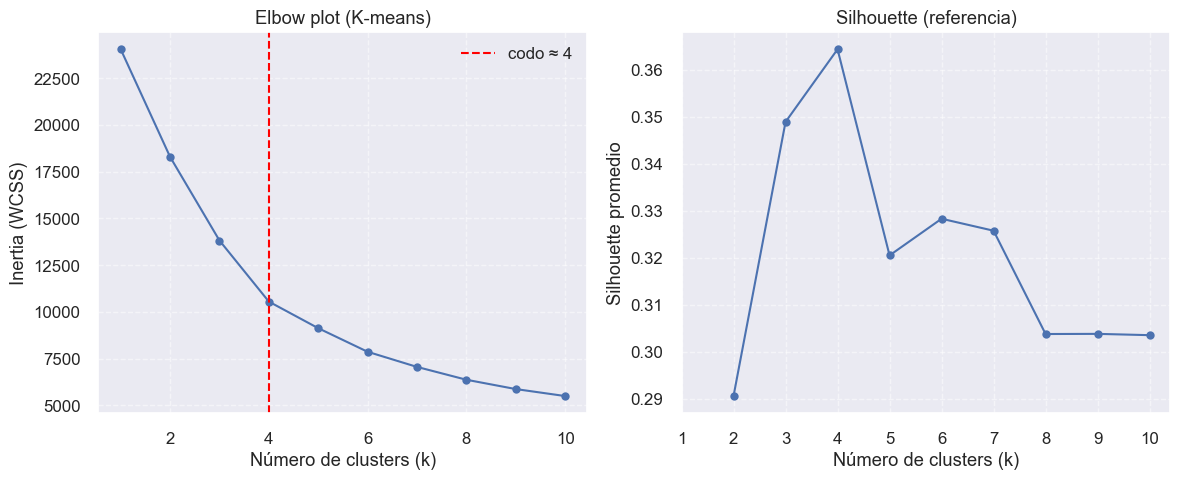


Evaluación para k=4: exactitud mayoritaria vs pobreza = 0.796
Distribución por clase dentro de cada cluster:
col_0      1      2      3      4
pobre                            
0      0.295  0.276  0.412  0.017
1      0.643  0.159  0.198  0.000


In [37]:
# Consigna 5b

# Elbow (K-means) con el mismo DF que la correlación (df_corr)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0) Tomar el DF de la matriz de correlación
try:
    base = df_corr.copy()
except NameError:
    raise NameError("No encuentro 'df_corr'. Corré antes la celda de la matriz de correlación.")

# 1) Asegurar las 6 variables (mismos nombres que usaste en df_corr)
vars6 = ["edad","edad2","educ","ingreso_total_familiar","miembros_hogar","horastrab"]
if "miembros_hogar" not in base.columns and "tot_p12" in base.columns:
    base["miembros_hogar"] = pd.to_numeric(base["tot_p12"], errors="coerce")

X_num = base[vars6].apply(pd.to_numeric, errors="coerce").dropna()
if X_num.empty:
    raise ValueError("Tras dropna, no quedaron filas para el análisis de K-means.")

# Eliminar columnas de varianza cero (por si acaso)
keep_cols = X_num.columns[X_num.var(ddof=0) > 0].tolist()
if len(keep_cols) < 2:
    raise ValueError("Menos de 2 variables con varianza>0 para clusterear.")
X = X_num[keep_cols]

# 2) Estandarizar
Z = StandardScaler().fit_transform(X.values)

# 3) Inertia (WCSS) y, opcionalmente, silhouette (k>=2)
inertias = []
silh = []
ks = list(range(1, 11))
for k in ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(Z)
    inertias.append(km.inertia_)
    if k >= 2 and len(np.unique(labels)) > 1:
        silh.append(silhouette_score(Z, labels))
    else:
        silh.append(np.nan)

inertias = np.array(inertias)
silh = np.array(silh)

# 4) Heurística del "codo": distancia máxima a la recta entre (k=1, I1) y (k=10, I10)
x = np.array(ks, dtype=float)
y = inertias.astype(float)
# vector de la recta
p1 = np.array([x[0], y[0]])
p2 = np.array([x[-1], y[-1]])
v = p2 - p1
v_norm = v / np.linalg.norm(v)
# distancia perpendicular de cada punto a la recta
dist = []
for i in range(len(x)):
    pi = np.array([x[i], y[i]])
    proj_len = np.dot(pi - p1, v_norm)
    proj = p1 + proj_len * v_norm
    dist.append(np.linalg.norm(pi - proj))
dist = np.array(dist)
k_elbow = int(x[np.argmax(dist)])

print("Columnas usadas para K-means:", keep_cols)
print("Inertia (k=1..10):", [round(v, 1) for v in inertias.tolist()])
print("k* (codo) sugerido por heurística geométrica:", k_elbow)

# 5) Gráficos: Elbow (inertia) y, opcional, silhouette
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Elbow plot
ax[0].plot(ks, inertias, marker="o")
ax[0].axvline(k_elbow, color="red", linestyle="--", label=f"codo ≈ {k_elbow}")
ax[0].set_xlabel("Número de clusters (k)")
ax[0].set_ylabel("Inertia (WCSS)")
ax[0].set_title("Elbow plot (K-means)")
ax[0].grid(True, linestyle="--", alpha=0.5)
ax[0].legend()

# Silhouette (opcional, informativo)
ax[1].plot(ks, silh, marker="o")
ax[1].set_xlabel("Número de clusters (k)")
ax[1].set_ylabel("Silhouette promedio")
ax[1].set_title("Silhouette (referencia)")
ax[1].set_xticks(ks)
ax[1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

# 6) (Opcional) ¿El k sugerido ayuda a distinguir pobreza?
def _find_col(df, *cands):
    up = {c.upper(): c for c in df.columns}
    for c in cands:
        if c and c.upper() in up: return up[c.upper()]
    return None

pobre_series = None
col_p = _find_col(base, "pobre", "POBRE")
if col_p:
    pobre_series = pd.to_numeric(base[col_p], errors="coerce")

# Si no está en df_corr, intento buscar en respondieron/base_final alineando por índice
if (pobre_series is None or pobre_series.reindex(X.index).isna().all()):
    for src_name in ("respondieron", "base_final"):
        if src_name in globals():
            src = globals()[src_name]
            colp = _find_col(src, "pobre", "POBRE")
            if colp:
                tmp = pd.to_numeric(src[colp], errors="coerce").reindex(X.index)
                if tmp.notna().any():
                    pobre_series = tmp
                    break

if pobre_series is not None and pobre_series.reindex(X.index).notna().any():
    # Reentreno con k_elbow y evalúo
    km_star = KMeans(n_clusters=k_elbow, n_init=20, random_state=42)
    labels_star = km_star.fit_predict(Z) + 1

    y_true = pobre_series.reindex(X.index)
    valid = y_true.notna()
    y = y_true[valid].astype(int).values
    c = labels_star[valid]

    # Mapeo cada cluster a la clase mayoritaria
    mapping = {}
    for cl in np.unique(c):
        cls_mean = y[c == cl].mean()
        mapping[cl] = int(cls_mean >= 0.5)  # 1 si mayoría pobres
    y_hat = np.array([mapping[cl] for cl in c])
    acc = (y_hat == y).mean()

    print(f"\nEvaluación para k={k_elbow}: exactitud mayoritaria vs pobreza = {acc:.3f}")
    print("Distribución por clase dentro de cada cluster:")
    print(pd.crosstab(y_true[valid], c, normalize="index").round(3))
else:
    print("\nNo se pudo evaluar contra 'pobre' (no encontrada o no alineada).")


In [38]:
# El grafico de elbow muestra una caida fuerte de la inercia entre k igual a 1 y k igual a 2 o 3, y luego rendimientos 
# decrecientes. Por inspeccion visual, el numero de grupos razonable esta entre 2 y 4, con k igual a 3 como buen equilibrio 
# entre ajuste y simplicidad. Con k igual a 2 la separacion entre pobres y no pobres es solo parcial, ya que hay solapamiento 
# cerca de la linea de pobreza. Con 3 o 4 grupos se obtienen segmentos socioeconomicos mas interpretables por combinaciones 
# de ingreso, educacion y horas trabajadas, pero no alcanza para clasificar la pobreza con alta precision.


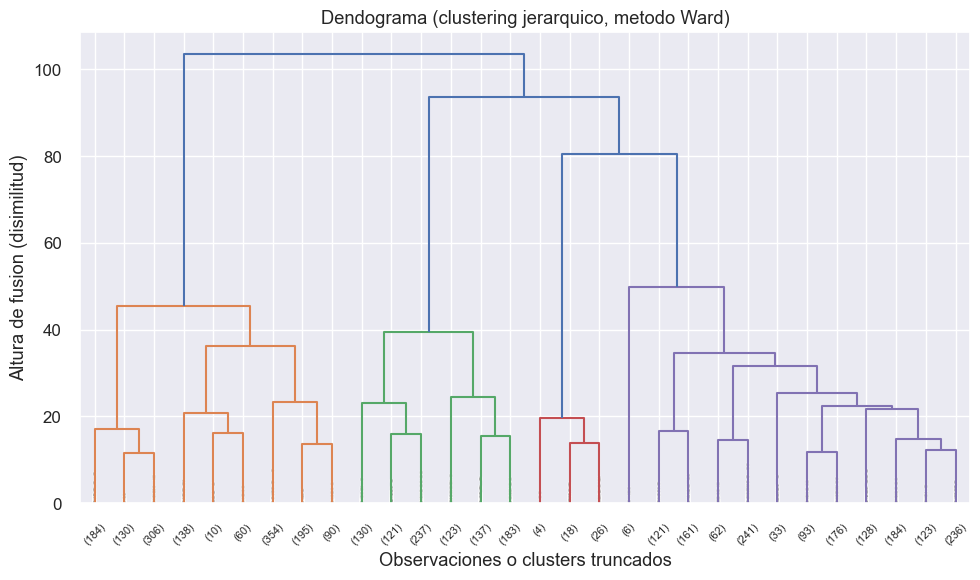

Observaciones usadas: 4010
Variables usadas: ['edad', 'edad2', 'educ', 'ingreso_total_familiar', 'miembros_hogar', 'horastrab']


In [39]:
# Consigna 6

# Clustering jerarquico + dendograma con las seis variables del TP, usando el mismo DF de la correlacion (df_corr)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram

# 0) Tomar el DF de la matriz de correlacion
try:
    X_raw = df_corr.copy()
except NameError:
    raise NameError("No encuentro 'df_corr'. Corre antes la celda que arma la matriz de correlacion.")

# 1) Asegurar las 6 variables con los mismos nombres
vars_hc = ["edad", "edad2", "educ", "ingreso_total_familiar", "miembros_hogar", "horastrab"]
if "miembros_hogar" not in X_raw.columns and "tot_p12" in X_raw.columns:
    X_raw["miembros_hogar"] = pd.to_numeric(X_raw["tot_p12"], errors="coerce")

X_num = X_raw[vars_hc].apply(pd.to_numeric, errors="coerce").dropna()

# 2) Estandarizar
Z = StandardScaler().fit_transform(X_num.values)

# 3) Enlace jerarquico (Ward + euclidea, recomendado tras estandarizar)
L = linkage(Z, method="ward")

# 4) Dendograma
n = Z.shape[0]
plt.figure(figsize=(10, 6))

if n <= 400:
    dendrogram(L, labels=None, leaf_rotation=90, leaf_font_size=8, color_threshold=None)
else:
    # Si hay muchas filas, usar un dendograma truncado para legibilidad
    dendrogram(
        L,
        truncate_mode="lastp",  # mostrar solo los ultimos p clusters fusionados
        p=30,                   # ajustar si queres mas/menos detalle
        leaf_font_size=8,
        show_contracted=True
    )

plt.title("Dendograma (clustering jerarquico, metodo Ward)")
plt.xlabel("Observaciones o clusters truncados")
plt.ylabel("Altura de fusion (disimilitud)")
plt.tight_layout()
plt.show()

print(f"Observaciones usadas: {n}")
print("Variables usadas:", vars_hc)


In [40]:
# Un dendograma es un diagrama en forma de arbol que representa las fusiones sucesivas del clustering jerarquico. 
# Cada bifurcacion muestra el momento en que dos grupos se unen y la altura indica la disimilitud a la que ocurre 
# esa union. Al cortar el dendograma a una determinada altura se obtiene un numero de clusters. Ramas largas y separadas 
# sugieren grupos bien diferenciados, mientras que ramas cortas indican separaciones debiles.

In [2]:
# Consigna 7

# K-modes con las MISMAS FILAS que df_corr (mismo sample/región), usando todas las dummies salvo 'pobre'
# Requiere: haber creado df_corr en ejercicios previos.
# Si falta 'kmodes', instalalo:  !pip install kmodes

import numpy as np
import pandas as pd

# 0) KModes
try:
    from kmodes.kmodes import KModes
except Exception:
    raise ImportError("Falta 'kmodes'. Instalalo con:  !pip install kmodes")

from pandas.api.types import (
    is_bool_dtype, is_object_dtype, is_integer_dtype, is_float_dtype
)
from pandas import CategoricalDtype

# -------- helpers --------
def find_col(df, *cands):
    up = {c.upper(): c for c in df.columns}
    for c in cands:
        if c and c.upper() in up: return up[c.upper()]
    return None

def es_dummy(s: pd.Series) -> bool:
    """Dummy si es booleana o si todos los valores no nulos son 0/1."""
    if is_bool_dtype(s): return True
    vals = pd.unique(s.dropna())
    if len(vals) == 0: return False
    if is_integer_dtype(s) or is_float_dtype(s):
        try:
            return set(pd.Series(vals, dtype="float64")) <= {0.0, 1.0}
        except Exception:
            return False
    return False

# 1) Tomo el MISMO conjunto de filas que df_corr
try:
    idx_anchor = df_corr.index
except NameError:
    raise NameError("No encuentro 'df_corr'. Corré antes la celda de la matriz de correlación.")

# 2) Busco el origen con categóricas para generar dummies, pero RESTRINGIDO a las filas de df_corr
#    Intento en este orden: df_reg (usado para la región) -> respondieron -> base_final
src = None
for name in ("df_reg", "respondieron", "base_final"):
    if name in globals():
        df_candidate = globals()[name]
        inter = df_candidate.index.intersection(idx_anchor)
        if len(inter) > 0:
            src = df_candidate.loc[inter].copy()
            # si df_corr tiene más filas que el inter, intento alinear por posición como fallback
            if len(inter) < len(idx_anchor) and isinstance(df_candidate.index, pd.RangeIndex) and isinstance(idx_anchor, pd.RangeIndex):
                # alineación posicional
                take = np.intersect1d(idx_anchor, df_candidate.index)
                src = df_candidate.loc[take].copy()
            break

if src is None:
    # como último recurso, si solo existe df_corr, no habrá categóricas; no se puede hacer k-modes
    raise ValueError("No encuentro un DataFrame origen con categóricas (df_reg/respondieron/base_final) para estas mismas filas.")

# 3) Alinear exactamente al índice de df_corr (mismas filas)
src = src.reindex(idx_anchor)

# 4) Detecto y excluyo 'pobre' si existe
col_pobre = find_col(src, "pobre", "POBRE")
y_pobre = pd.to_numeric(src[col_pobre], errors="coerce") if col_pobre else None

# 5) Tomo TODAS las dummies ya presentes y, si faltan, genero dummies desde categóricas
dummy_cols = []
for c in src.columns:
    if col_pobre and c == col_pobre: 
        continue
    if es_dummy(src[c]):
        dummy_cols.append(c)

# si hay pocas dummies, creo desde object/CategoricalDtype (siempre excluyendo 'pobre')
if len(dummy_cols) < 5:
    cat_cols = []
    for c in src.columns:
        if col_pobre and c == col_pobre: 
            continue
        if is_object_dtype(src[c]) or isinstance(src[c].dtype, CategoricalDtype):
            cat_cols.append(c)
    if len(cat_cols) > 0:
        dums = pd.get_dummies(src[cat_cols], drop_first=False, dtype="uint8")
        X_full = pd.concat([src.drop(columns=cat_cols, errors="ignore"), dums], axis=1)
        src = X_full
        dummy_cols = [c for c in src.columns if (not col_pobre or c != col_pobre) and es_dummy(src[c])]
    # si aun así no hay dummies suficientes, lo informo
    if len(dummy_cols) == 0:
        raise ValueError("No hay variables dummies disponibles en estas mismas filas. Verificá que el origen tenga categóricas.")

# 6) Construyo X con solo dummies; convierto a 0/1; relleno NaN con 0; elimino columnas constantes
X = src[dummy_cols].copy()

for c in X.columns:
    if is_bool_dtype(X[c]):
        X[c] = X[c].astype("uint8")
    else:
        X[c] = pd.to_numeric(X[c], errors="coerce")

X = X.fillna(0).astype("uint8")
const_cols = [c for c in X.columns if X[c].nunique(dropna=False) <= 1]
if const_cols:
    X = X.drop(columns=const_cols)

if X.shape[0] == 0 or X.shape[1] == 0:
    raise ValueError("Luego de limpiar, no hay filas o dummies válidas para k-modes en estas mismas filas.")

print(f"Filas usadas (mismas que df_corr): {X.shape[0]} | Dummies usadas: {X.shape[1]}")

# 7) K-modes para k = 2, 4, 10
ks = [2, 4, 10]
labels_dict = {}
models = {}

for k in ks:
    km = KModes(n_clusters=k, init="Huang", n_init=20, random_state=42, verbose=0)
    lab = km.fit_predict(X.values) + 1  # clusters desde 1
    labels = pd.Series(lab, index=X.index, name=f"cluster_k{k}")
    labels_dict[k] = labels
    models[k] = km
    sizes = labels.value_counts().sort_index()
    print(f"k = {k} | tamaños por cluster:", sizes.to_dict())

# 8) Evaluación: con k=2, comparar contra pobreza (si existe para estas filas)
if y_pobre is not None:
    y_aligned = y_pobre.reindex(X.index)
    if y_aligned.notna().any():
        labs2 = labels_dict[2]
        ct = pd.crosstab(y_aligned.astype("Int64"), labs2, normalize="index")
        print("\nDistribución de clusters dentro de cada clase de pobreza (k=2):")
        print(ct.round(3))
        # exactitud por mayoría
        valid = y_aligned.notna()
        yv = y_aligned[valid].astype(int).values
        cv = labs2[valid].values
        mapping = {}
        for cl in np.unique(cv):
            mapping[cl] = int((yv[cv == cl].mean()) >= 0.5)  # 1 si mayoría pobres
        y_hat = np.array([mapping[cl] for cl in cv])
        acc = (y_hat == yv).mean()
        print(f"Exactitud por mayoría (k=2): {acc:.3f}")
    else:
        print("\nNo se pudo evaluar contra 'pobre': no hay valores no nulos en estas mismas filas.")
else:
    print("\nNo se encontró 'pobre' para evaluar la separación con k=2 en estas mismas filas.")


NameError: No encuentro 'df_corr'. Corré antes la celda de la matriz de correlación.